# Python for data analysis and visualisation: Data Segmentation PoC with Streamlit Cloud Application

Let's try to extract customers characteristics by their spending habits.
We'll use the data from the [Customer Personality Analysis](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data) kaggle project.

Goals:
- Get familiar with data
- Make quick data analysis using [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/)
- Fit clustering algorithm - [k-Means](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.)
- Extract main characteristics of the retrieved clusters

In [1]:
# import necessary packages and objects
import os
import sys

import re
import datetime
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# set format of floats displayed in outputs
pd.options.display.float_format = '{:.3f}'.format

# Constants

In [3]:
RANDOM_STATE = 42 # to get the same random values with different .ipynb sessions

In [4]:
PROJECT_PATH = os.getcwd() # get current working directory
PROJECT_PATH = os.path.join(PROJECT_PATH, "..") # go to higher folder 

DATA_PATH = os.path.join(PROJECT_PATH, "data") # define path to the data

# Read Data

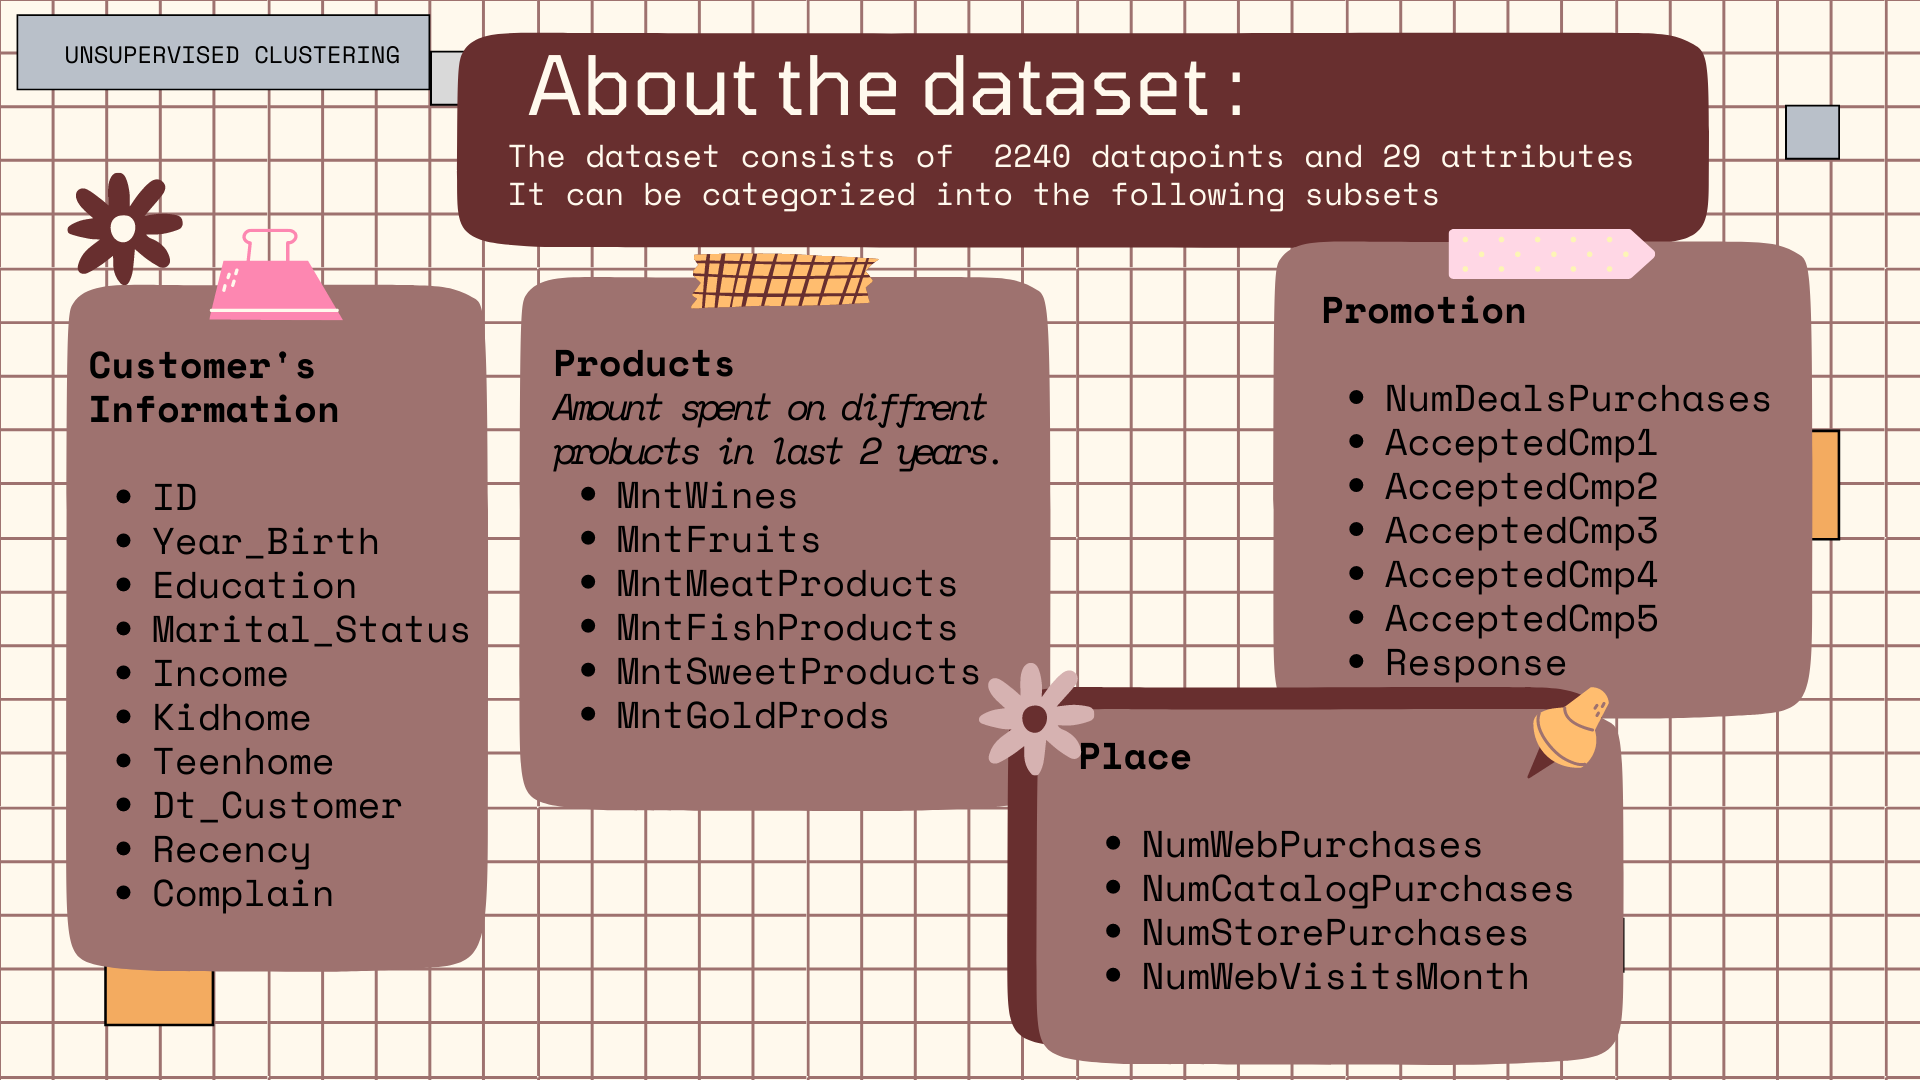
[Image's source](https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering)

**People:**

_ID_:Customer's unique identifier<br>
_Year_Birth_:Customer's birth year<br>
_Education_:Customer's education level<br>
_Marital_Status_:Customer's marital status<br>
_Income_:Customer's yearly household income<br>
_Kidhome_:Number of children in customer's household<br>
_Teenhome_:Number of teenagers in customer's household<br>
_Dt_Customer_:Date of customer's enrollment with the company<br>
_Recency_:Number of days since customer's last purchase<br>
_Complain_:1 if the customer complained in the last 2 years, 0 otherwise<br>

**Products**:<br>

_MntWines_:Amount spent on wine in last 2 years<br>
_MntFruits_:Amount spent on fruits in last 2 years<br>
_MntMeatProducts_:Amount spent on meat in last 2 years<br>
_MntFishProducts_:Amount spent on fish in last 2 years<br>
_MntSweetProducts_:Amount spent on sweets in last 2 years<br>
_MntGoldProds_:Amount spent on gold in last 2 years<br>

**Promotion:**<br>

_NumDealsPurchases_:Number of purchases made with a discount<br>
_AcceptedCmp1_:1 if customer accepted the offer in the 1st campaign, 0 otherwise<br>
_AcceptedCmp2_:1 if customer accepted the offer in the 2nd campaign, 0 otherwise<br>
_AcceptedCmp3_:1 if customer accepted the offer in the 3rd campaign, 0 otherwise<br>
_AcceptedCmp4_:1 if customer accepted the offer in the 4th campaign, 0 otherwise<br>
_AcceptedCmp5_:1 if customer accepted the offer in the 5th campaign, 0 otherwise<br>
_Response_:1 if customer accepted the offer in the last campaign, 0 otherwise<br>

**Place:**<br>

_NumWebPurchases_:Number of purchases made through the company’s website<br>
_NumCatalogPurchases_:Number of purchases made using a catalogue<br>
_NumStorePurchases_:Number of purchases made directly in stores<br>
_NumWebVisitsMonth_:Number of visits to company’s website in the last month<br>

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, "marketing_campaign.csv"), sep="\t")

In [6]:
df.head()

ID  Year_Birth   Education Marital_Status    Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single 58138.000        0         0   
1  2174        1954  Graduation         Single 46344.000        1         1   
2  4141        1965  Graduation       Together 71613.000        0         0   
3  6182        1984  Graduation       Together 26646.000        1         0   
4  5324        1981         PhD        Married 58293.000        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [8]:
# check for Nulls
print("# of Nulls in `Incomes`: ", df.Income.isnull().sum())

# of Nulls in `Incomes`:  24


In [9]:
# remove records with Nulls
df = df[~df.Income.isnull()].reset_index(drop=True)

In [10]:
print("If any duplicated rows: ", df.duplicated().any())
print("If any duplicated `ID`s: ", df.ID.duplicated().any())

If any duplicated rows:  False
If any duplicated `ID`s:  False


In [11]:
print("# customers: ", df.shape[0])

# customers:  2216


# EDA

## Feature Engineering

In [12]:
# define list of columns to train model
COLS_TO_TRAIN = []

### TotalSpends

_TotalSpends_ - total amount of money spent by category. It will be used to generate other features and to describe clusters.

In [13]:
# extract all columns from the dataset, which starts with "Mnt", as only these columns contain info about spends by a corresponding category
spent_cols = [col for col in df.columns if re.findall("^Mnt*", col) != []]

print("# cols: ", len(spent_cols))
print("Categories of spends: ", spent_cols)

# cols:  6
Categories of spends:  ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']


In [14]:
# sum of the spends by all categories 
df["TotalSpends"] = df[spent_cols].sum(axis=1)

In [15]:
df.TotalSpends.describe()

count   2216.000
mean     607.075
std      602.900
min        5.000
25%       69.000
50%      396.500
75%     1048.000
max     2525.000
Name: TotalSpends, dtype: float64

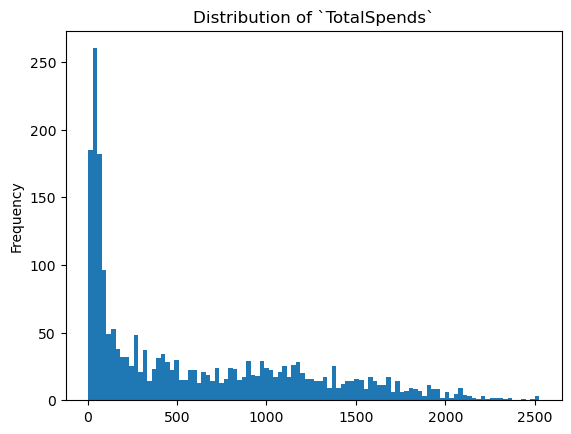

In [16]:
_ = df["TotalSpends"].plot(kind="hist", bins=100, title="Distribution of `TotalSpends`")

In [17]:
# check if there are cases with Incomes less than spends
# Incomes are multiplied by 2 because our Spends are by the last 2 years
df[df.Income * 2 < df.TotalSpends]

Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response, TotalSpends]
Index: []

[0 rows x 30 columns]

### %SpendOn{Category}

 _%SpendOn{Category}_ - is a general name, where {Category} will be replaced with every value from {"Wines", "Fruits", "MeatProducts", "FishProducts", "SweetProducts", "GoldProds"}. These features will be used to fit K-Means.

In [18]:
print("Categories of spends: ", spent_cols)

Categories of spends:  ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']


In [19]:
# create a column's name for each category 
spent_on_cat_cols = ["%SpendOn" + re.split("^Mnt*", col)[1] for col in spent_cols]
print("Names: ", spent_on_cat_cols)

Names:  ['%SpendOnWines', '%SpendOnFruits', '%SpendOnMeatProducts', '%SpendOnFishProducts', '%SpendOnSweetProducts', '%SpendOnGoldProds']


In [20]:
# compute features
# pandas DataFrame and Series objects are transformed to numpy arrays because
# - numpy arrays automatically brodcast dimensions: (2216, 6) /  (2216, 1) => (2216, 6)
df[spent_on_cat_cols] = (
    df[spent_cols].to_numpy() / df["TotalSpends"].to_numpy().reshape((-1, 1))
).round(3)

In [21]:
# check for Nulls
print("If Nulls in just created columns: ", df[spent_on_cat_cols].isnull().any().any())
print("If inf in just created columns: ", df[spent_on_cat_cols].isin([np.inf]).any().any())

If Nulls in just created columns:  False
If inf in just created columns:  False


In [22]:
# check distributions of the just created columns:
df[spent_on_cat_cols].describe()

%SpendOnWines  %SpendOnFruits  %SpendOnMeatProducts  \
count       2216.000        2216.000              2216.000   
mean           0.459           0.050                 0.249   
std            0.229           0.056                 0.126   
min            0.000           0.000                 0.000   
25%            0.290           0.009                 0.156   
50%            0.458           0.030                 0.233   
75%            0.641           0.070                 0.328   
max            0.963           0.446                 0.997   

       %SpendOnFishProducts  %SpendOnSweetProducts  %SpendOnGoldProds  
count              2216.000               2216.000           2216.000  
mean                  0.072                  0.051              0.120  
std                   0.078                  0.061              0.109  
min                   0.000                  0.000              0.000  
25%                   0.013                  0.009              0.038  
50%                   0.048                  0.033              0.086  
75%                   0.105                  0.070              0.170  
max                   0.591                  0.946              0.894

In [23]:
# add just created columns to the list of columns to fit clustering algorithm on
COLS_TO_TRAIN += spent_on_cat_cols
del spent_on_cat_cols

### NPurchPerVisit

_NPurchPerVisit_ - number of purchases by the website's visits. This feature will be used only to describe clusters.

In [24]:
# check if there are cases, that several purchases were completed by one visit
print(
    "# cases, when several purchases were done by one session: ", 
    (df.NumWebVisitsMonth < df.NumWebPurchases).sum()
)

# cases, when several purchases were done by one session:  865


In [25]:
# check distributions of "NumWebVisitsMonth", "NumWebPurchases": 
df[["NumWebVisitsMonth", "NumWebPurchases"]].describe()

NumWebVisitsMonth  NumWebPurchases
count           2216.000         2216.000
mean               5.319            4.085
std                2.425            2.741
min                0.000            0.000
25%                3.000            2.000
50%                6.000            4.000
75%                7.000            6.000
max               20.000           27.000

In [26]:
# generate feature
df["NPurchPerVisit"] = df.NumWebPurchases / df.NumWebVisitsMonth 

In [27]:
# assign 0 to the cases, when the website wasn't visited
df.loc[df.NumWebVisitsMonth == 0, "NPurchPerVisit"] = 0

In [28]:
print("If any Nulls: ", df["NPurchPerVisit"].isnull().any())
print("If any infs: ", df["NPurchPerVisit"].isin([np.inf]).any())

If any Nulls:  False
If any infs:  False


In [29]:
# check feature's distribution
df["NPurchPerVisit"].describe()

count   2216.000
mean       1.078
std        1.212
min        0.000
25%        0.333
50%        0.750
75%        1.500
max       27.000
Name: NPurchPerVisit, dtype: float64

### Age

_Age_ - number of years a person has. This feature will be used only for the clusters analysis.

In [30]:
# extract a year of birth from the current year
df["Age"] = datetime.date.today().year - df["Year_Birth"]

In [31]:
# check the distribution
df.Age.describe()

count   2216.000
mean      55.180
std       11.986
min       28.000
25%       47.000
50%       54.000
75%       65.000
max      131.000
Name: Age, dtype: float64

In [32]:
print(
    "% of customers with `Age` > 100: {:.2f}%".format(
        df[df.Age > 100].shape[0] * 100 / df.shape[0]
    )
)

% of customers with `Age` > 100: 0.14%


In [33]:
# remove observations, we (our client) are not interested in 
# as that are rare cases, but we'd like to portrait a common user
df = df[df.Age < 100].reset_index(drop=True)

In [34]:
# check the distribution after removal
df.Age.describe()

count   2213.000
mean      55.083
std       11.700
min       28.000
25%       47.000
50%       54.000
75%       65.000
max       84.000
Name: Age, dtype: float64

## Check on outliers 

### Income

In [35]:
# check the distribution
df.Income.describe()

count     2213.000
mean     52236.582
std      25178.603
min       1730.000
25%      35246.000
50%      51373.000
75%      68487.000
max     666666.000
Name: Income, dtype: float64

In [36]:
print(
    "% of customers with `Income` > 125k: {:.2f}%".format(
        df[df.Income > 125000].shape[0] * 100 / df.shape[0]
    )
)

% of customers with `Income` > 125k: 0.36%


In [37]:
# remove the records we (our client) are not interested in 
# as that are rare cases, but we'd like to portrait a common user
df = df[df.Income < 125000].reset_index(drop=True)

In [38]:
# check the distribution after removals
df.Income.describe()

count     2205.000
mean     51622.095
std      20713.064
min       1730.000
25%      35196.000
50%      51287.000
75%      68281.000
max     113734.000
Name: Income, dtype: float64

In [39]:
# Multiply Incomes by 2 as TotalSpends are by the last 2 years
df.Income *= 2

In [40]:
# check distributions of the Income, TotalSpends:
pd.merge(
    df.Income.describe(), 
    df.TotalSpends.describe(), 
    left_index=True, right_index=True
)

Income  TotalSpends
count   2205.000     2205.000
mean  103244.190      606.822
std    41426.128      601.675
min     3460.000        5.000
25%    70392.000       69.000
50%   102574.000      397.000
75%   136562.000     1047.000
max   227468.000     2525.000

In [41]:
print(f"% of Income is spent in the current shop, on average: {(397 / 102574):.2%}")

% of Income is spent in the current shop, on average: 0.39%


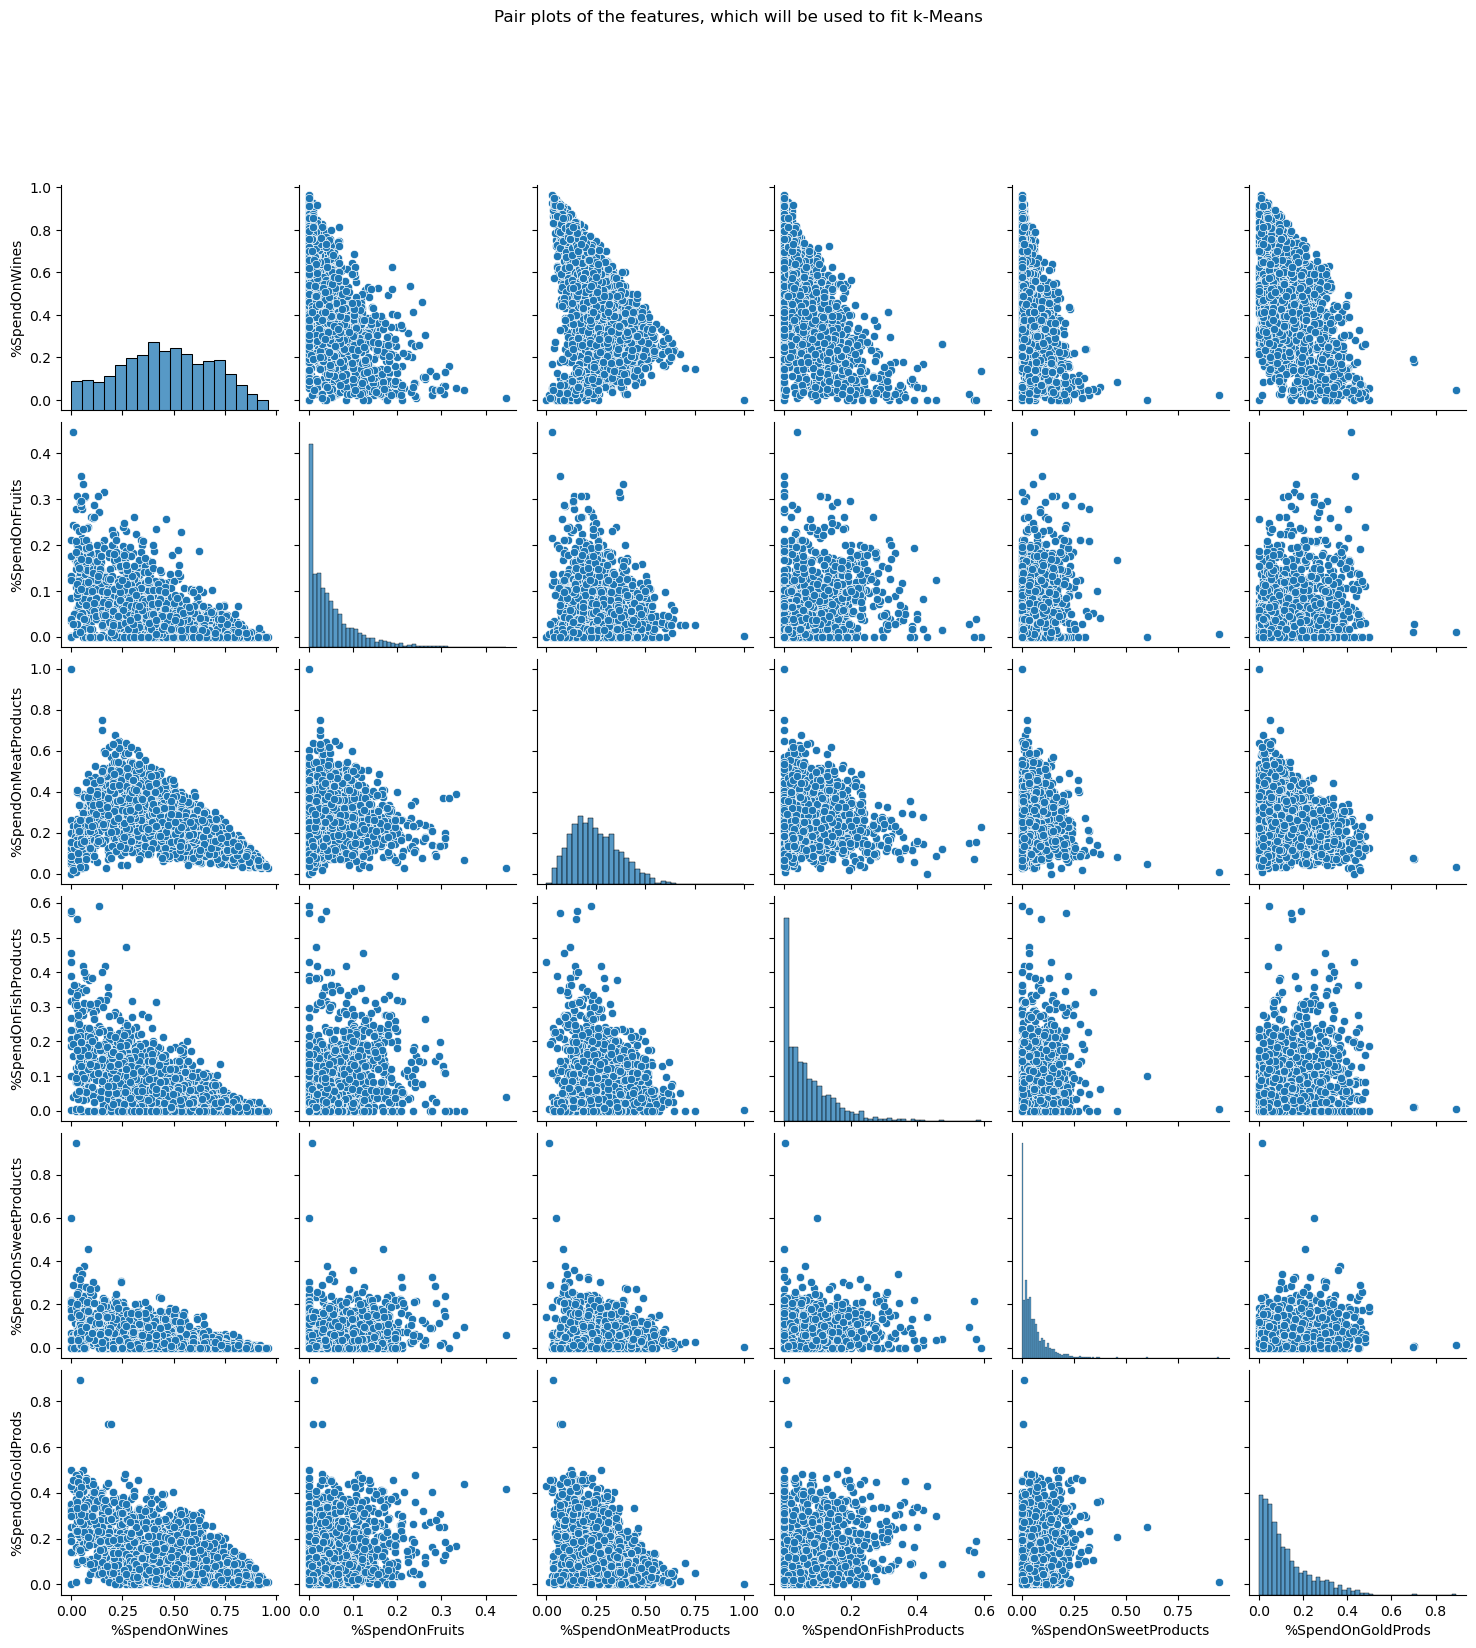

In [42]:
# Check if there is any obvious clusters  
f = sns.pairplot(df[COLS_TO_TRAIN])
_ = f.fig.suptitle("Pair plots of the features, which will be used to fit k-Means", y=1.1)

# Extract clusters

## Preprocessing

In [43]:
df_stnd = (df[COLS_TO_TRAIN] - df[COLS_TO_TRAIN].mean()) / df[COLS_TO_TRAIN].std()

In [44]:
print("If any Nulls: ", df_stnd.isnull().any().any())

If any Nulls:  False


## k-Means

The [**K-Means**](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.) algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 

Given a set of observations $(X_1, X_2, ..., X_n)$, where each observation is a d-dimensional real vector, k-means clustering aims to partition the $n$ observations into $k (≤ n)$ sets $S = \{S_1, S_2, ..., S_k\}$ so as to minimize variance. Formally, the objective is to find:

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/da7224953bfc4bc270f6d9546bf2ed18aad1ccb3'>

where $μ_i$ is the mean (also called centroid) of points in 

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/5f5ae4b286ef97d61ea3f66cd4779e05e1062750"> 

$|S_{i}|$ is the size of $S_{i}$, and $‖⋅‖$ is the usual $L_2$ norm.


<img src="..\data\kmeans.gif"> 

To learn more about k-Means in sklearn: [link](https://scikit-learn.org/stable/modules/clustering.html#k-means)

### K-selection by Elbow Method

The [**Elbow Method**](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is a graphical method for finding the optimal K value in a k-means clustering algorithm. The elbow graph shows the within-cluster-sum-of-square (WCSS) values on the y-axis corresponding to the different values of K (on the x-axis). The optimal K value is the point at which the graph forms an elbow.

$$Interia = WSS = \sum_{c=1}^{C}\sum_{j=1}^{N}{(X_{j,c} - X_c)^2}$$

$X_{j, c}$ - $j-th$ customer, who belongs to the cluster $c$, $j=\{1, ..., N\}, c=\{1, ..., C\}$;

$X_c$ - the coordinates of the $c-th$ center

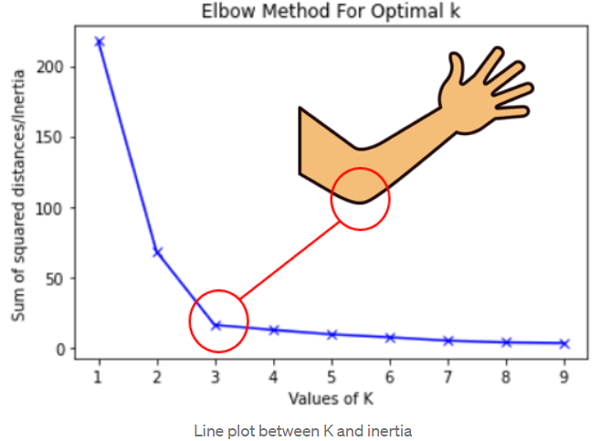

In [45]:
# Let's define the initial set of parameters for k-means 
K_MEANS_PARAMS = dict(
    random_state=RANDOM_STATE, 
)

In [46]:
K = 10 # maximum number of clusters to test
k_wss = dict.fromkeys(range(1, K + 1)) # initialize dict to save WSS for each k

for k in range(1, K + 1):
    K_MEANS_PARAMS.update(n_clusters=k) # update number of clusters in params used for K-Means training
    kmeans =  KMeans(**K_MEANS_PARAMS) 
    kmeans.fit(df_stnd)
    k_wss[k] = kmeans.inertia_ # extract and save WSS

c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The 

In [47]:
# convert the dictionary with WSSs to the pd.DataFrame 
k_wss = pd.DataFrame.from_dict(k_wss, orient="index", columns=["WSS"])

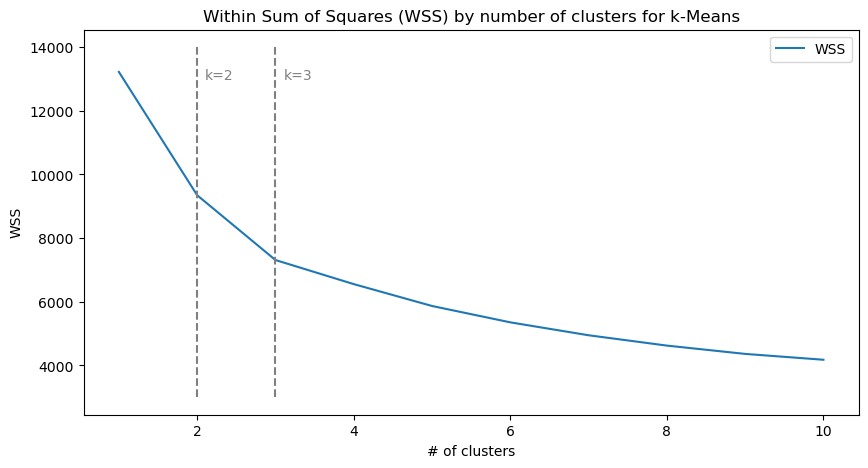

In [48]:
# plot Elbow Diagram
_ = k_wss.plot(
    kind="line", 
    figsize=(10, 5),
    title="Within Sum of Squares (WSS) by number of clusters for k-Means",
    xlabel="# of clusters",
    ylabel="WSS"
)

# add elbow's candidates
# k=2
_ = plt.vlines(x=2, ymin=3000, ymax=14e3, linestyles="--", color="gray")
_ = plt.annotate("k=2", (2.1, 13e3), color="gray")

# k=3
_ = plt.vlines(x=3, ymin=3000, ymax=14e3, linestyles="--", color="gray")
_ = plt.annotate("k=3", (3.1, 13e3), color="gray")

### k=2

In [49]:
# train k-Means with k=2
K_MEANS_PARAMS.update(n_clusters=2) # update the only parameter, which should be chanegd

kmeans = KMeans(**K_MEANS_PARAMS)
kmeans.fit(df_stnd[COLS_TO_TRAIN])

# generate predictions
df["k=2"] = kmeans.predict(df_stnd[COLS_TO_TRAIN]).astype(str)

c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [50]:
# generate palette to plot features by the clusters so that, 
# - greenish corresponds to richer people 
# - redish - to poorer individuals
PALETTE = dict()
PALETTE['k=2'] = dict(
    zip(
        df.groupby(["k=2"], sort=False).TotalSpends.median().sort_values().index, 
        ("red", "green")
    )
)

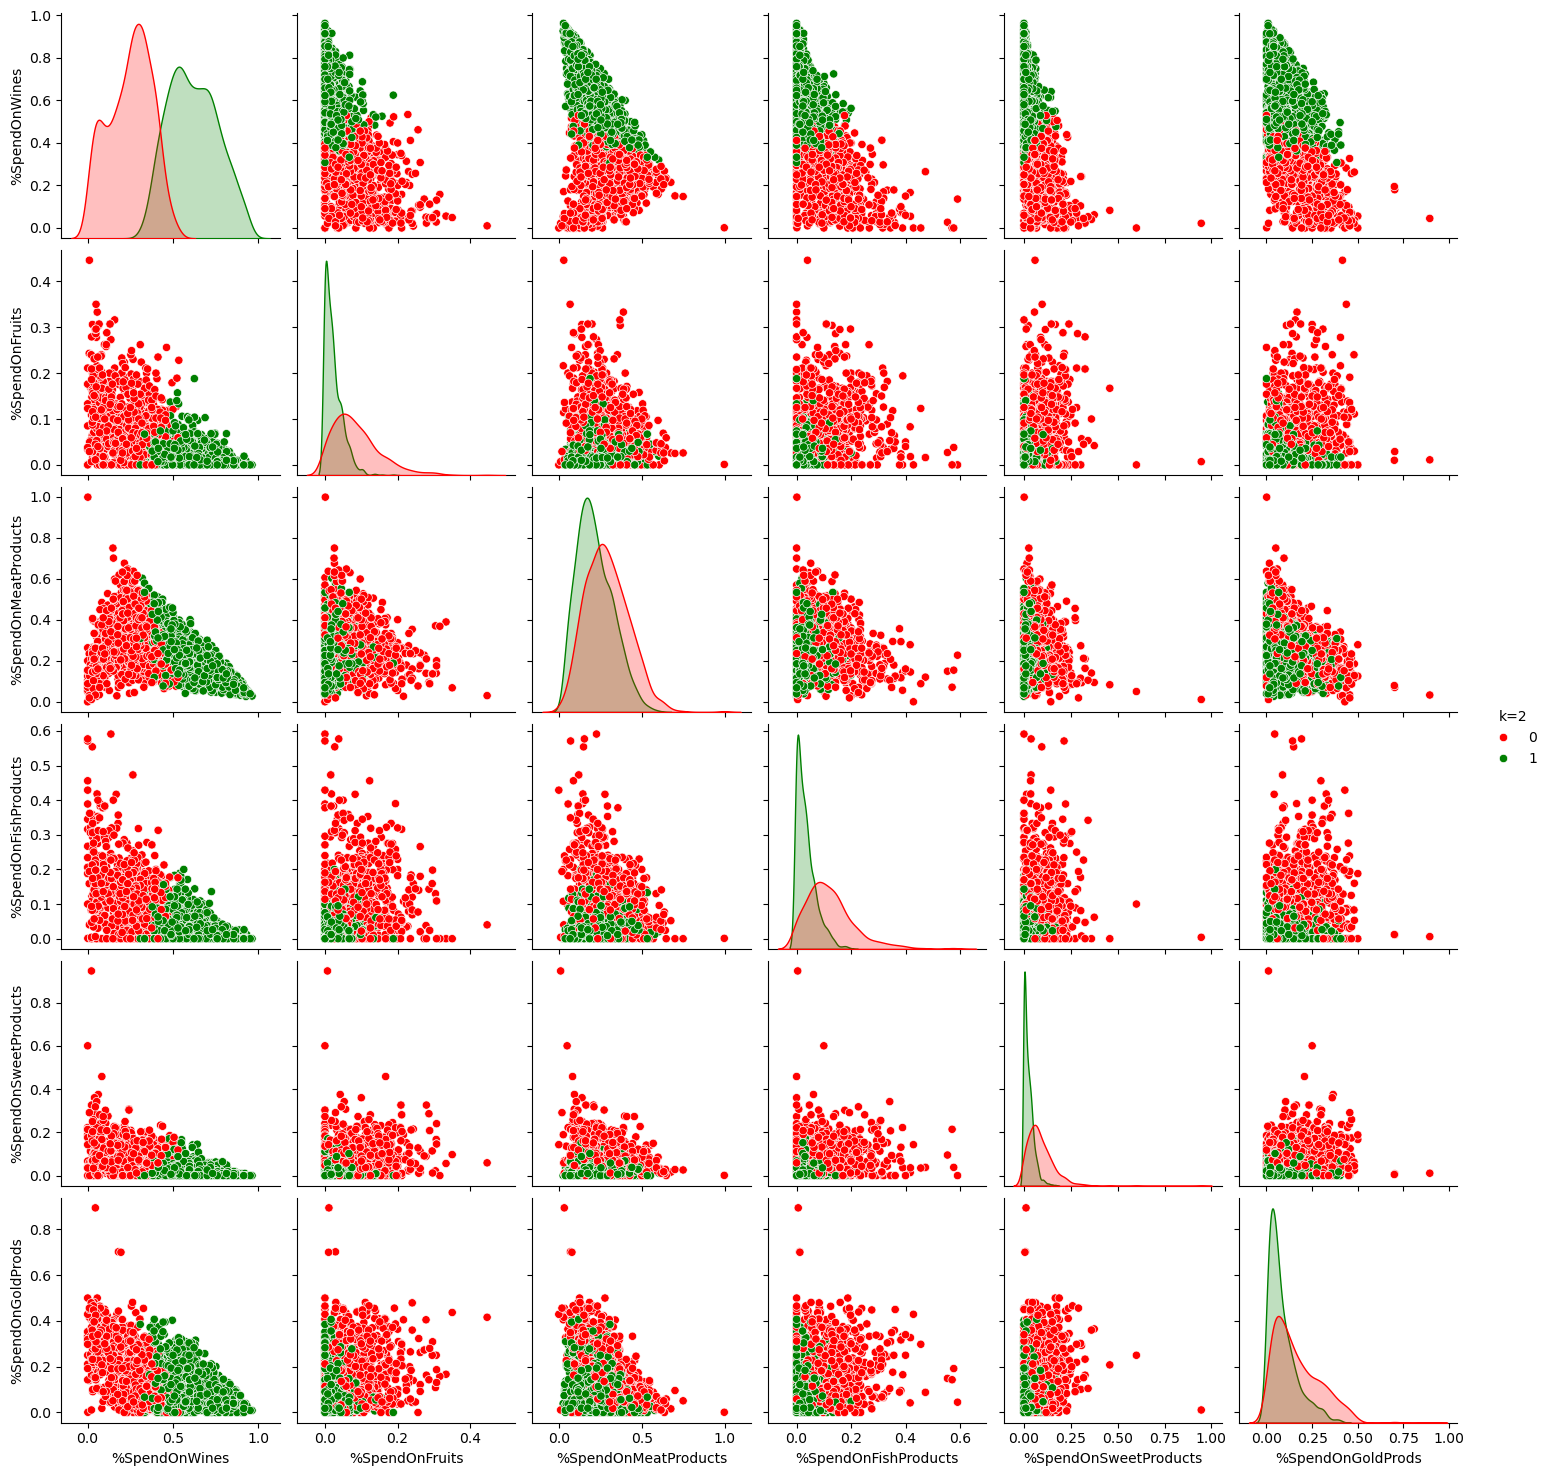

In [51]:
# plot feautres dependencies by clusters
_ = sns.pairplot(
    df[COLS_TO_TRAIN + ["k=2"]], 
    hue="k=2", 
    palette=PALETTE['k=2'], 
    diag_kws=dict(common_norm=False)
)

In [52]:
# extract categories names from the corresponding col names
# to rename columns
print("Initial: ", spent_cols)
categories = [col[3:-8] if "Products" in col else col[3:] for col in spent_cols]
categories = [col[:-5] if 'Prods' in col else col for col in categories]
print("Final: ", categories)

Initial:  ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
Final:  ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']


In [53]:
# renaming
df.rename(columns=dict(zip(spent_cols, categories)), inplace=True)

In [54]:
# define columns, which won't be used for extraction info about clusters
COLS_TO_DISPLAY = [
    col for col in df.columns if "Accepted" not in col
] # spoiler: no big diff by these features between clusters

for col in [
    'ID', # no need
    'Year_Birth', # Age is used instead
    'k=2', # stores out clusters
    'Dt_Customer', # YearsBeingb
    'Z_CostContact', 
    'Z_Revenue',
    'Marital_Status' 
]:
    COLS_TO_DISPLAY.remove(col)

C:\Users\hdychko\AppData\Local\Temp\ipykernel_27900\948038130.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  _ = sns.boxplot(
C:\Users\hdychko\AppData\Local\Temp\ipykernel_27900\948038130.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  _ = sns.stripplot(
C:\Users\hdychko\AppData\Local\Temp\ipykernel_27900\948038130.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  _ = sns.boxplot(
C:\Users\hdychko\AppData\Local\Temp\ipykernel_27900\948038130.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` 

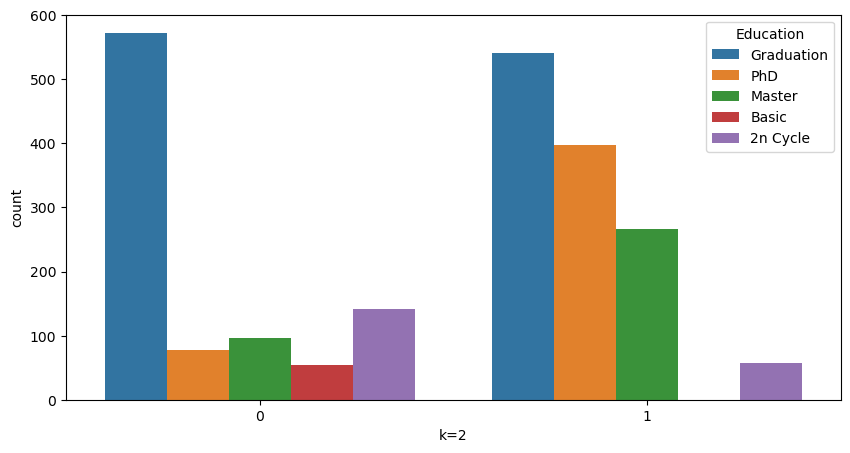

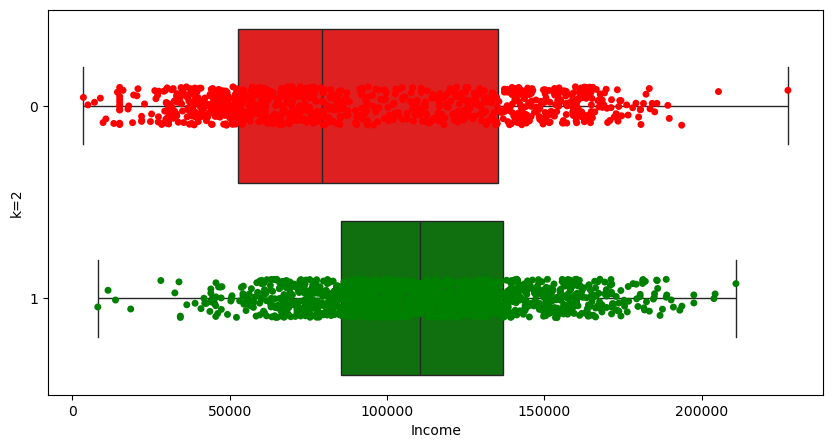

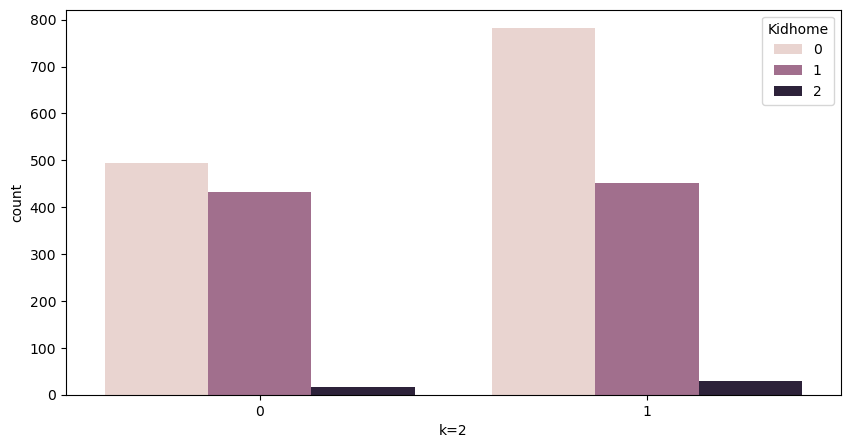

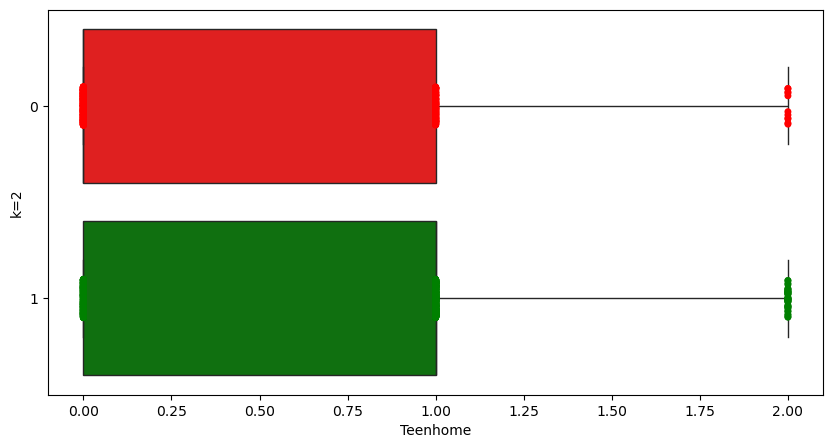

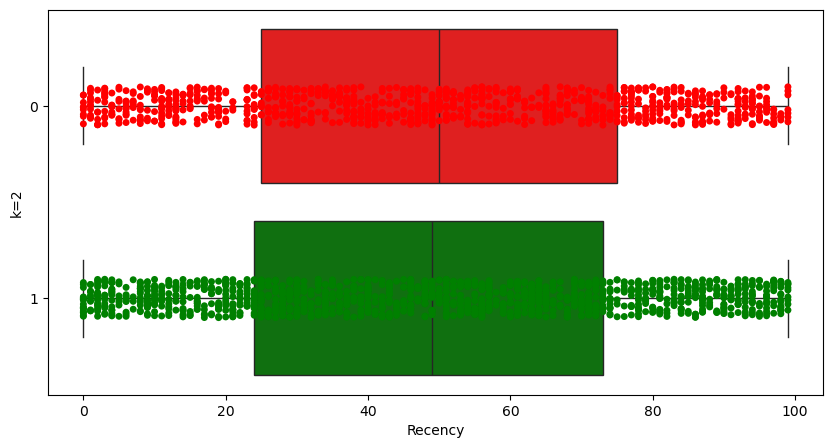

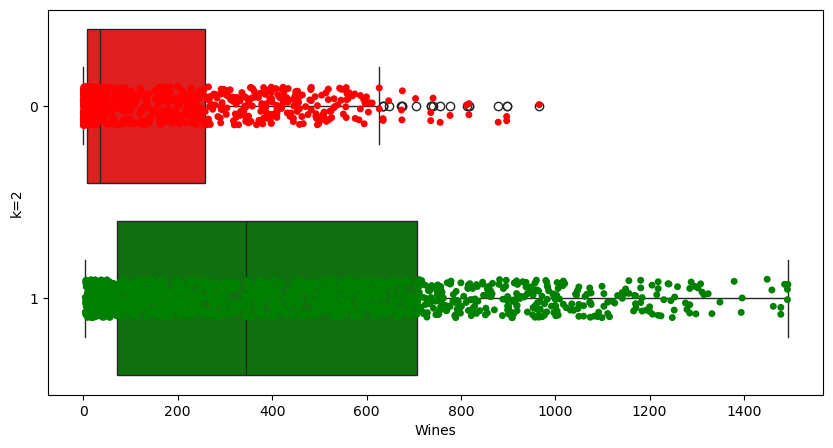

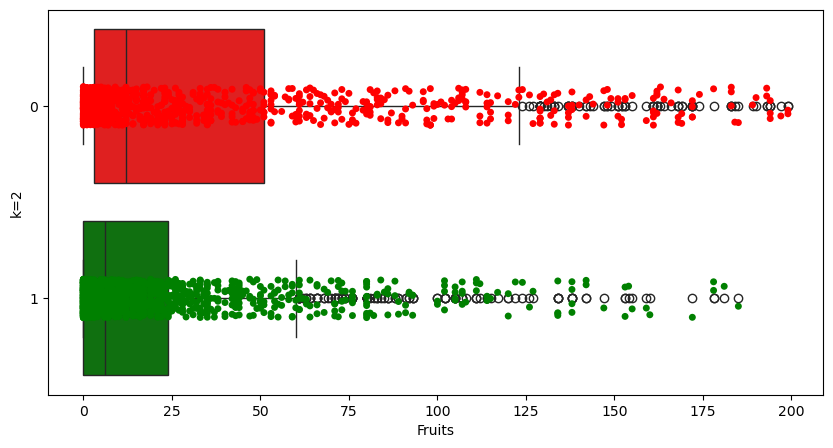

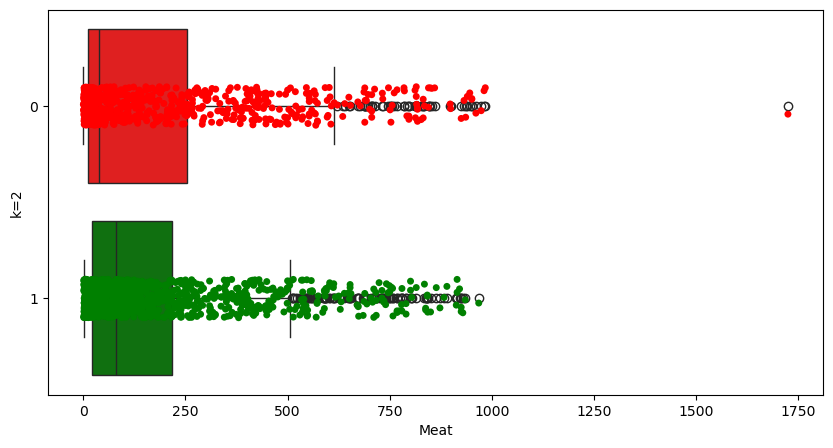

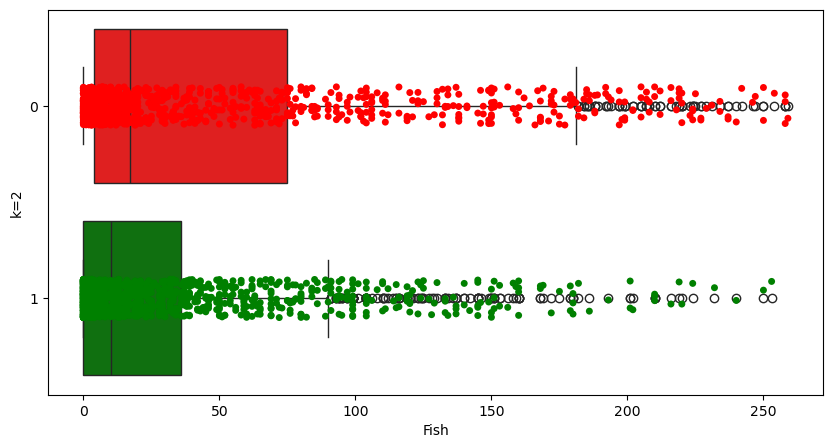

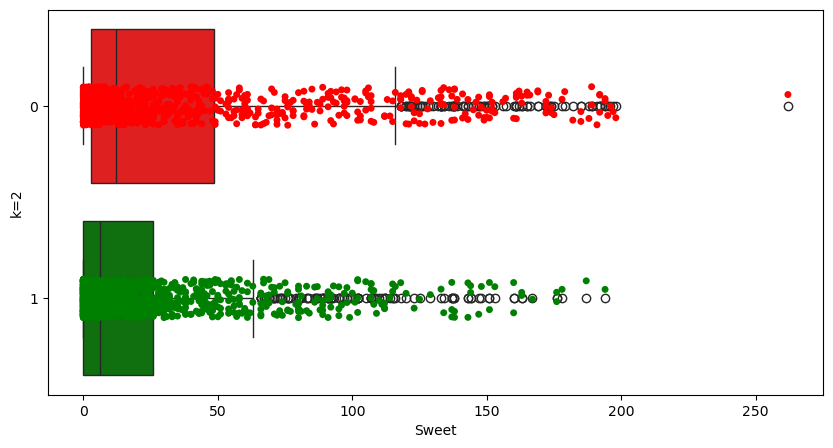

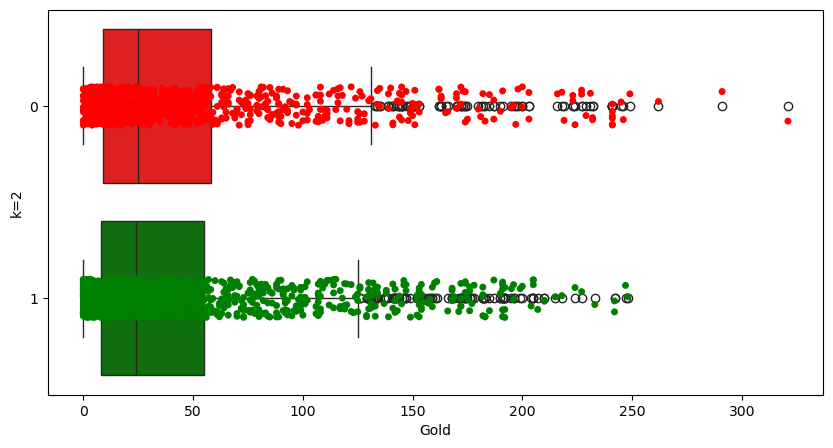

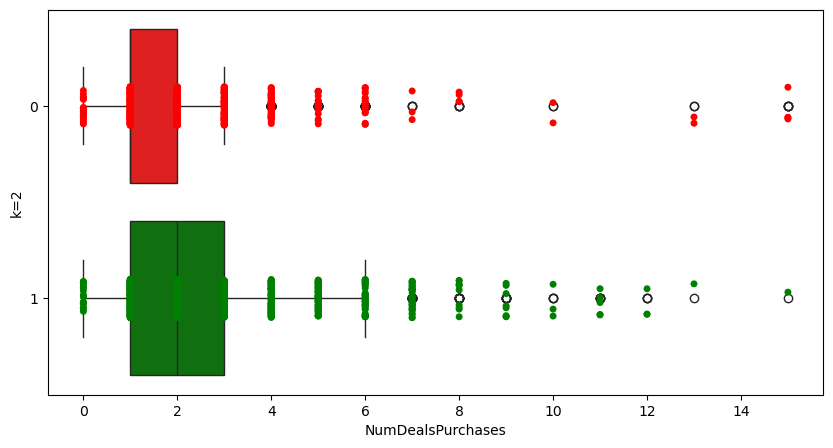

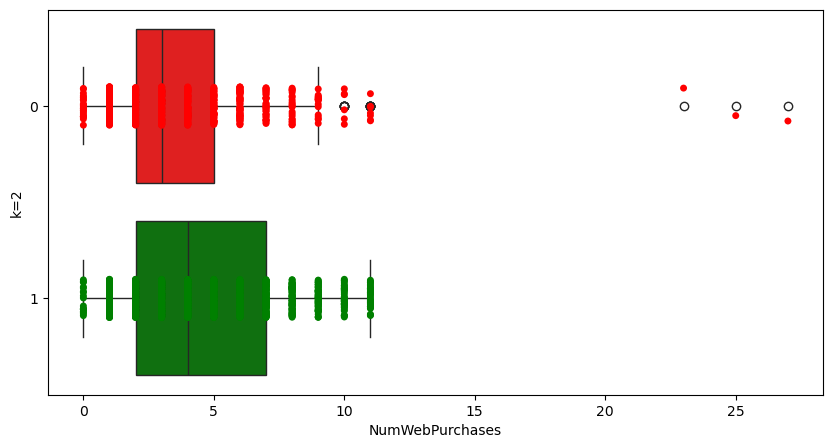

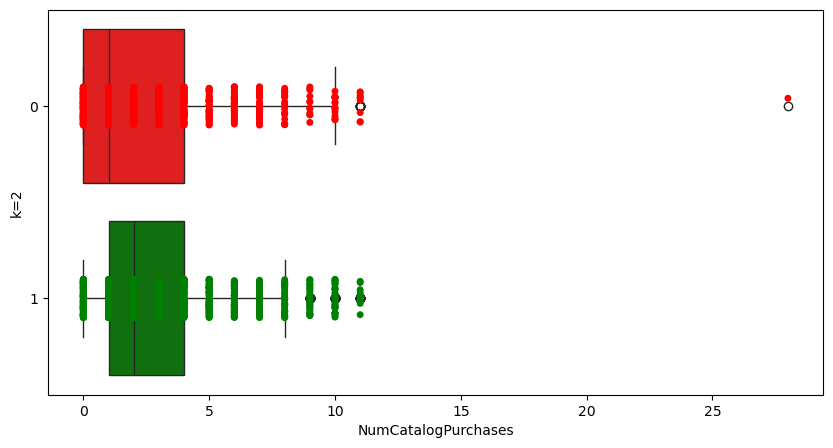

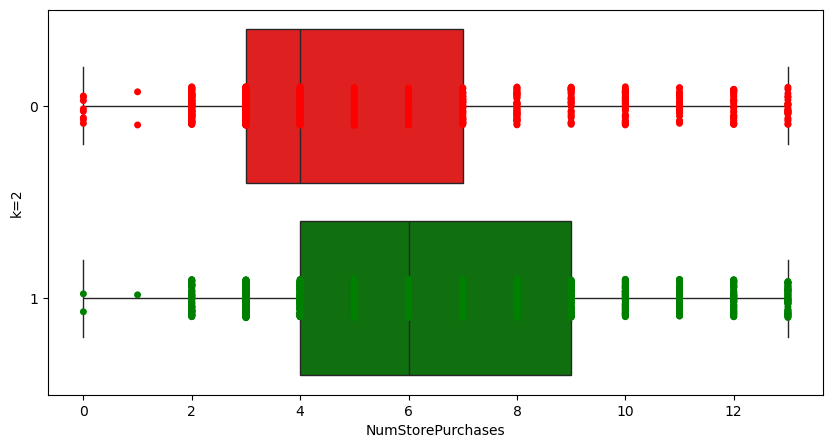

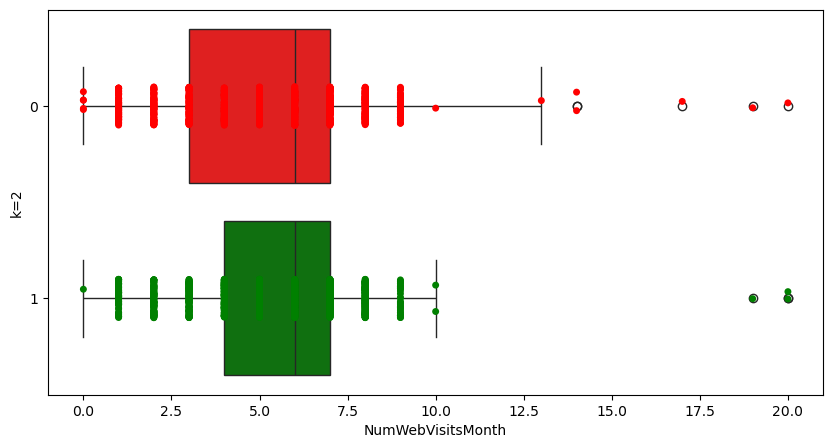

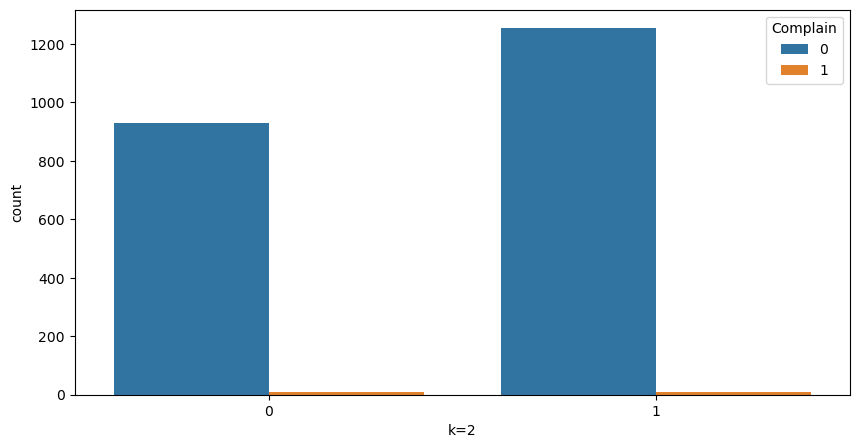

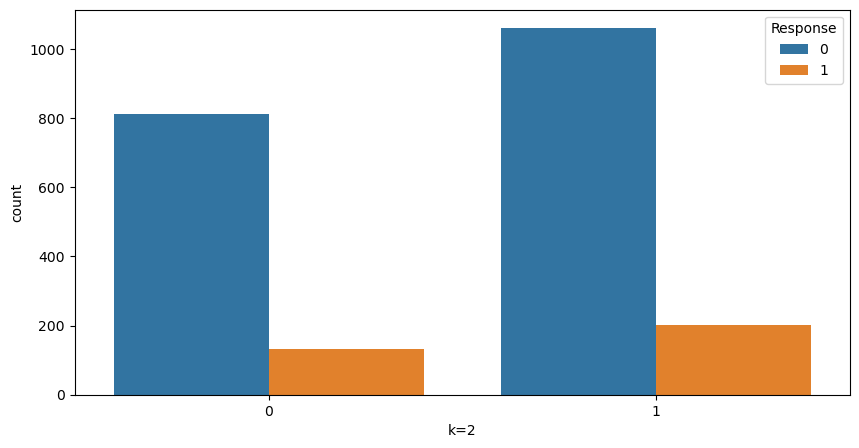

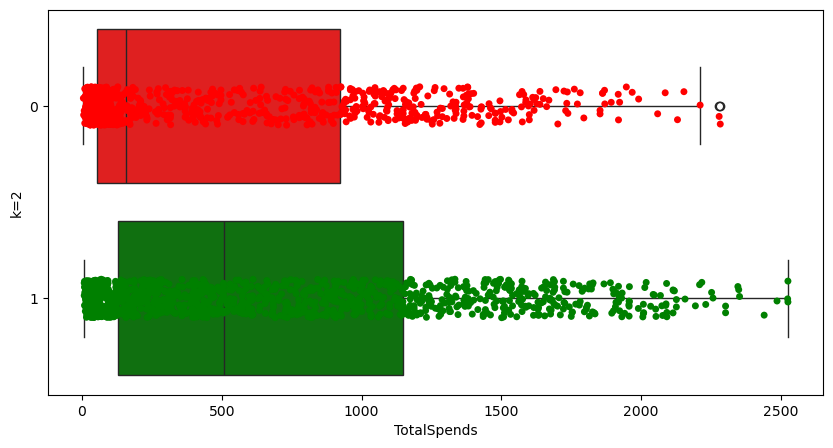

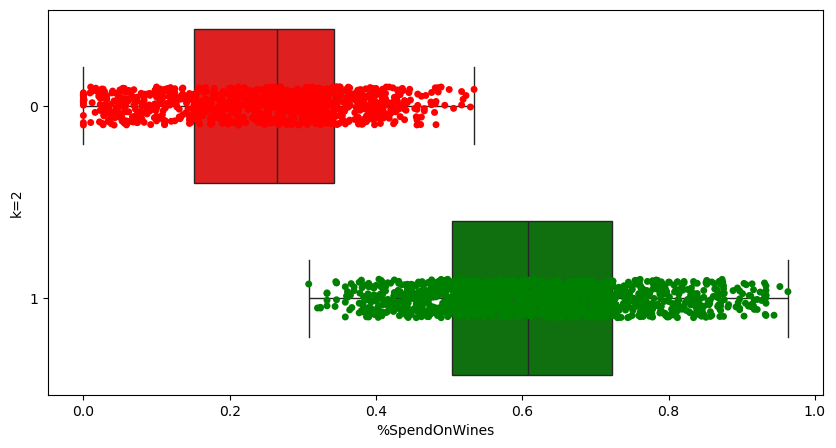

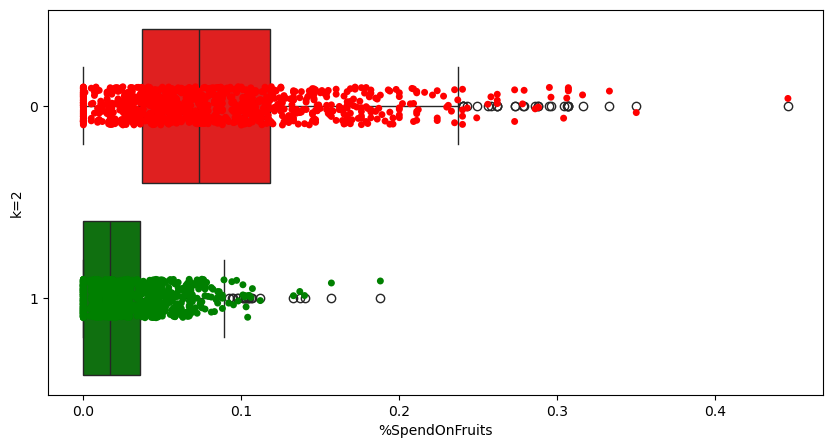

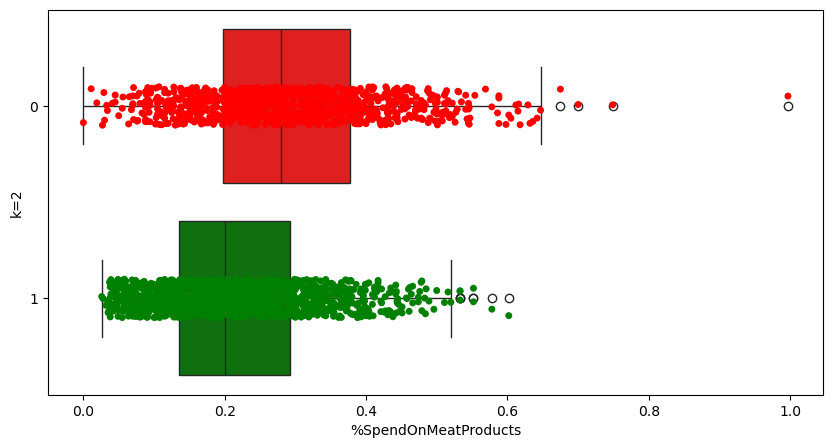

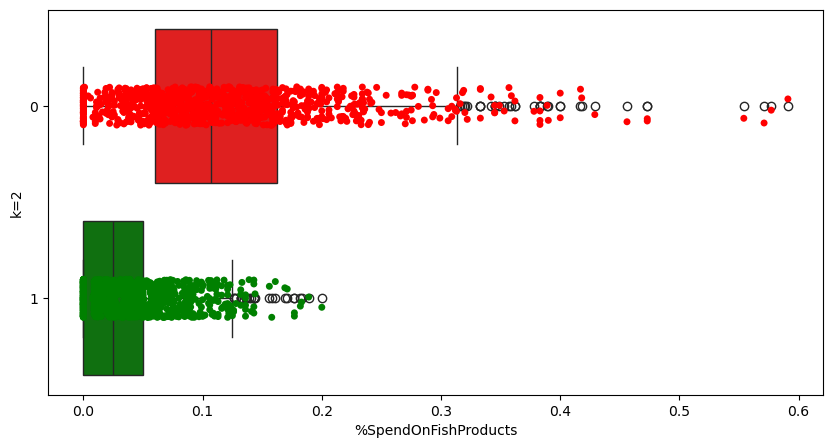

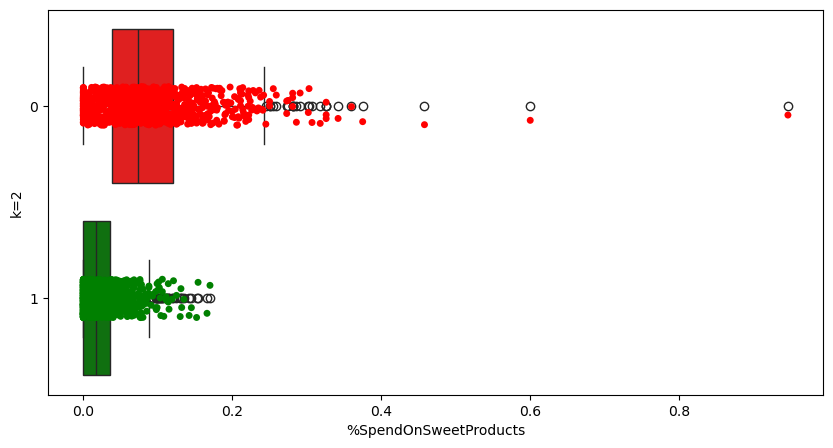

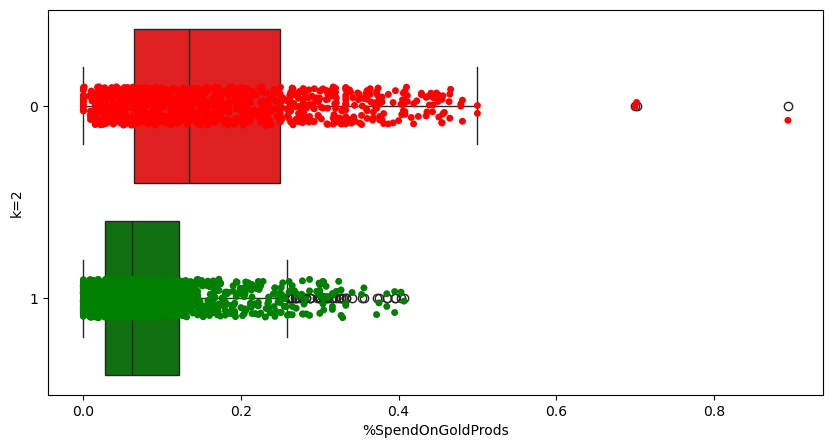

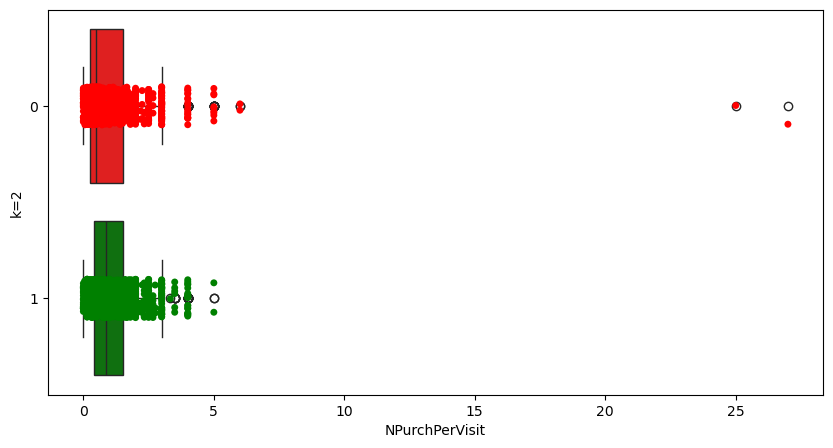

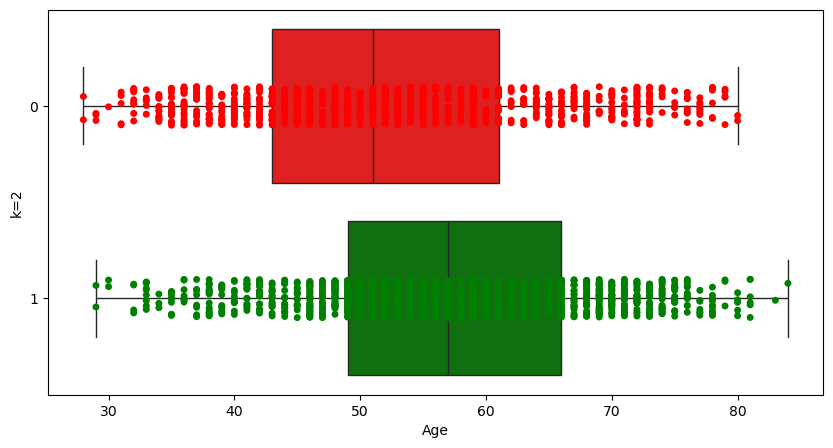

In [55]:
# distributions by clusters
for col in COLS_TO_DISPLAY:
    _ = plt.figure(figsize=(10, 5))
    if col not in ['Kidhome', "Complain", "Response", "YearsBeingCustomer", 'Relationship'] + list(df.dtypes[df.dtypes == "object"].index):
        _ = sns.boxplot(
            data=df, x=col, y="k=2", orient="h",
            palette=PALETTE['k=2']
        )
        _ = sns.stripplot(
            data=df, x=col, y="k=2", orient="h",
            palette=PALETTE['k=2']
        )
    else:
        _ = sns.countplot(data=df, x="k=2", hue=col)

In [56]:
# define columns to differentiate cluster by
# medians will be computed for these columns and displayed in the app
PLOT_PARAMS = {
    'k=2': [
        "Wines",
        'TotalSpends',
        'Income',
        '%SpendOnWines',
        '%SpendOnFruits',
        '%SpendOnFishProducts', 
        '%SpendOnSweetProducts',
        '%SpendOnGoldProds'
    ]
}

In [57]:
# computer medians
# -- for the whole dataset
df_stats = pd.DataFrame(df[PLOT_PARAMS['k=2']].describe(percentiles=[0.5]).loc['50%']).T.reset_index(drop=True)
df_stats['k=2'] = 'Overall'

# -- by the clusters
df_stats_kmeans = df.groupby(['k=2'])[PLOT_PARAMS['k=2']].apply(lambda x: x.describe(percentiles=[0.5]).loc['50%']).reset_index()

# concatenate statistics for the whole dataset & computed separetly on clusters
df_stats = pd.concat((df_stats_kmeans, df_stats)).reset_index(drop=True)
del df_stats_kmeans
df_stats.set_index('k=2', inplace=True)

df_stats

Wines  TotalSpends     Income  %SpendOnWines  %SpendOnFruits  \
k=2                                                                      
0        35.000      156.000  79232.000          0.265           0.073   
1       344.000      507.000 110564.000          0.608           0.017   
Overall 178.000      397.000 102574.000          0.459           0.030   

         %SpendOnFishProducts  %SpendOnSweetProducts  %SpendOnGoldProds  
k=2                                                                      
0                       0.107                  0.073              0.134  
1                       0.025                  0.017              0.062  
Overall                 0.048                  0.033              0.086

In [58]:
# convert data types for fancy visualization in the app
for col in ['TotalSpends', 'Income', 'Wines']:
    df_stats[col] = df_stats[col].astype(int)

for col in COLS_TO_TRAIN:
    if col in df_stats.columns:
        df_stats[col] = df_stats[col].round(3)

In [59]:
df_stats['Wines'] = df_stats['Wines'].round(1)

In [60]:
df_stats

Wines  TotalSpends  Income  %SpendOnWines  %SpendOnFruits  \
k=2                                                                  
0           35          156   79232          0.265           0.073   
1          344          507  110564          0.608           0.017   
Overall    178          397  102574          0.459           0.030   

         %SpendOnFishProducts  %SpendOnSweetProducts  %SpendOnGoldProds  
k=2                                                                      
0                       0.107                  0.073              0.134  
1                       0.025                  0.017              0.062  
Overall                 0.048                  0.033              0.086

In [61]:
df_stats.to_pickle(os.path.join(DATA_PATH, 'k_means_keq2.pckl'))

### k=3

In [62]:
# train k-Means with k=3
K_MEANS_PARAMS.update(n_clusters=3)

kmeans = KMeans(**K_MEANS_PARAMS)
kmeans.fit(df_stnd[COLS_TO_TRAIN])

# generate predictions
df["k=3"] = kmeans.predict(df_stnd[COLS_TO_TRAIN]).astype(str)

c:\Users\hdychko\Anaconda3\envs\segmentation\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [63]:
# generate palette to plot features by the clusters
PALETTE['k=3'] = dict(
    zip(
        df.groupby(["k=3"], sort=False).Income.median().sort_values().index, 
        ("red", "orange", "green")
    )
)

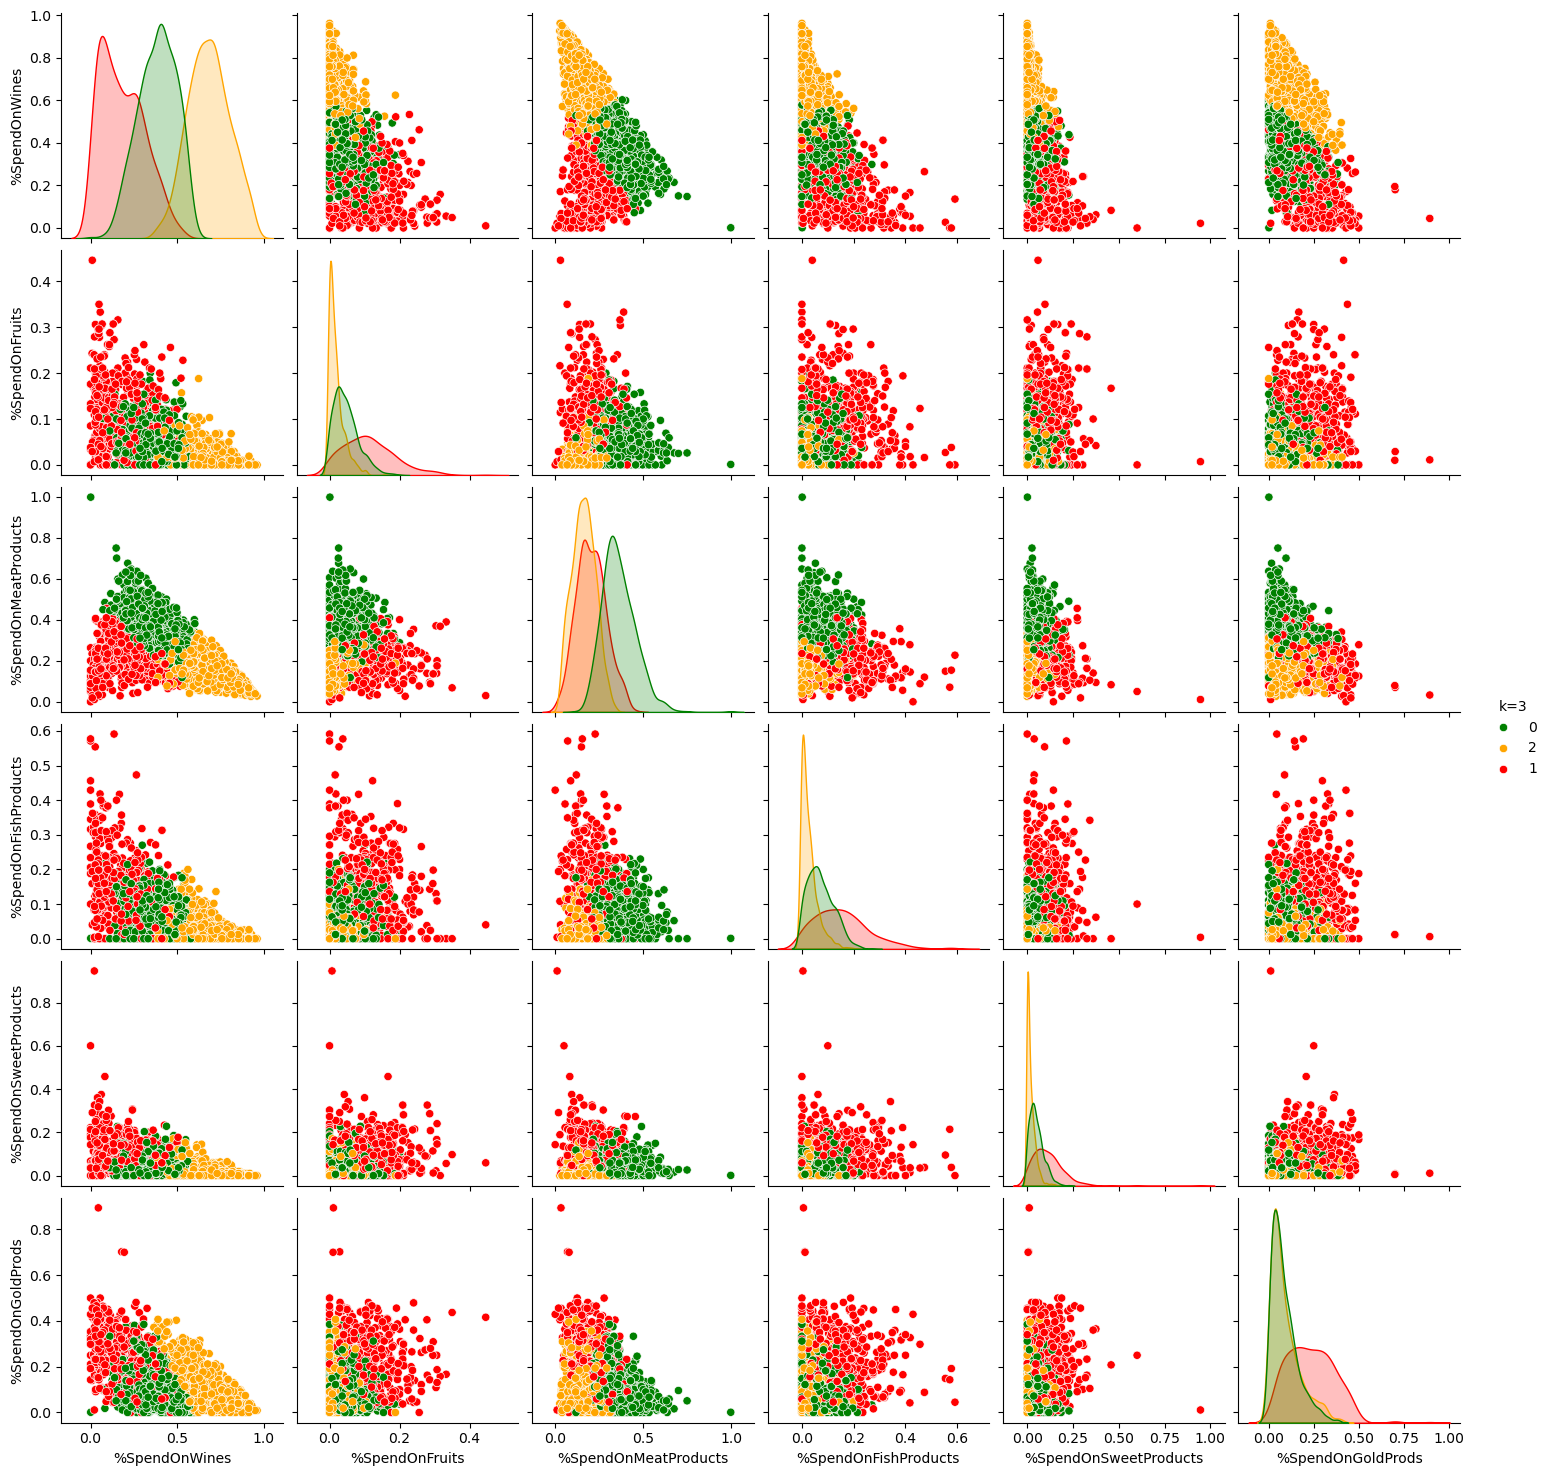

In [64]:
# generate palette to plot features by the clusters so that, 
# - greenish corresponds to richer people 
# - yellowish - middle incomes
# - redish - to poorer individuals

_ = sns.pairplot(
    df[COLS_TO_TRAIN + ["k=3"]], 
    hue="k=3", 
    palette=PALETTE['k=3'], 
    diag_kws=dict(common_norm=False)
)

C:\Users\hdychko\AppData\Local\Temp\ipykernel_23296\3211560512.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  _ = sns.boxplot(
C:\Users\hdychko\AppData\Local\Temp\ipykernel_23296\3211560512.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  _ = sns.stripplot(
C:\Users\hdychko\AppData\Local\Temp\ipykernel_23296\3211560512.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  _ = sns.boxplot(
C:\Users\hdychko\AppData\Local\Temp\ipykernel_23296\3211560512.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

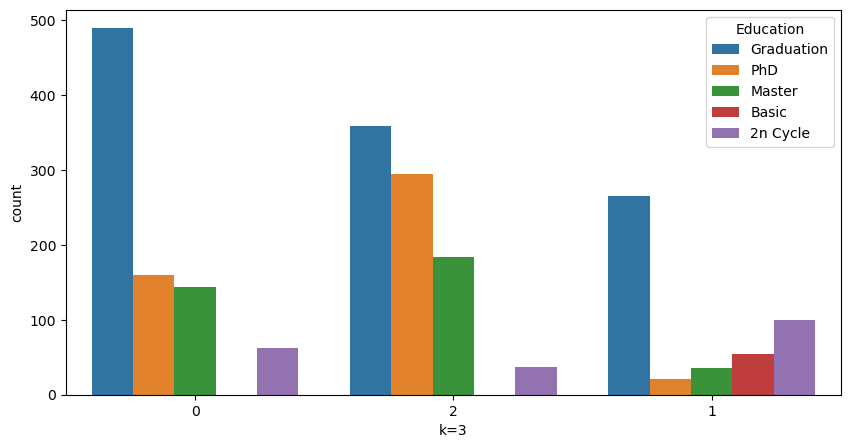

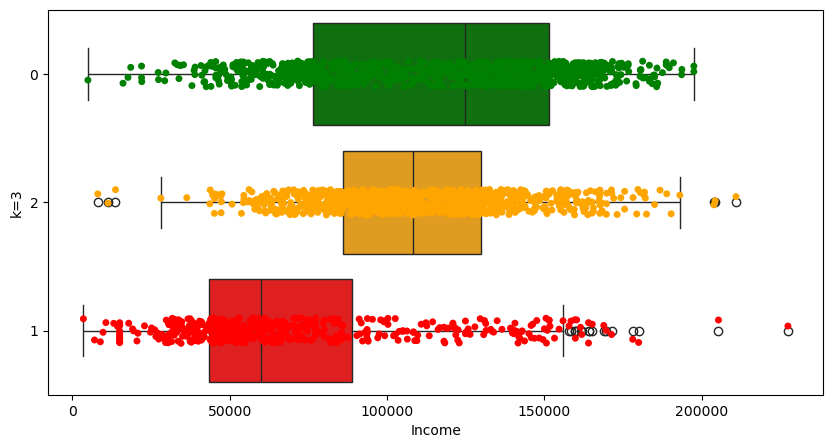

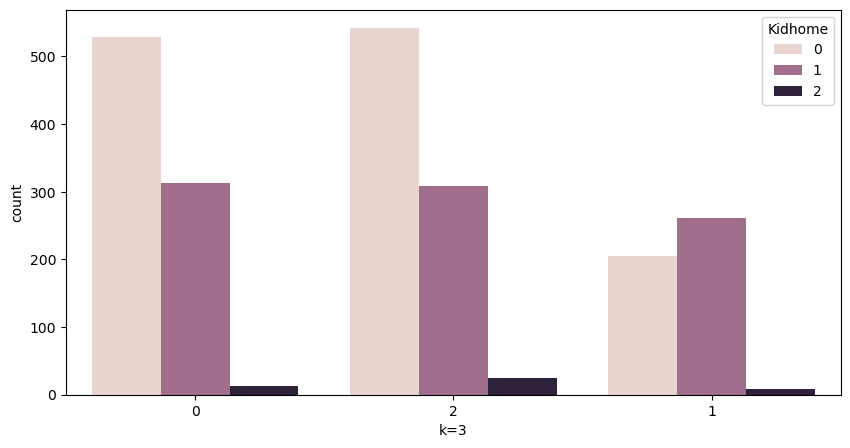

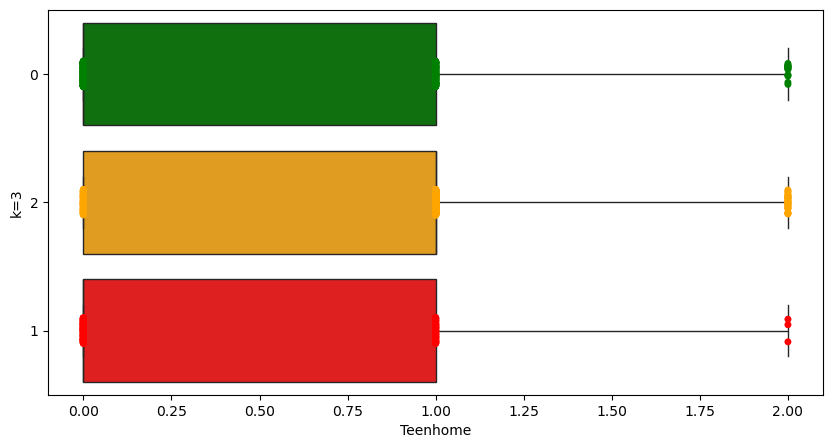

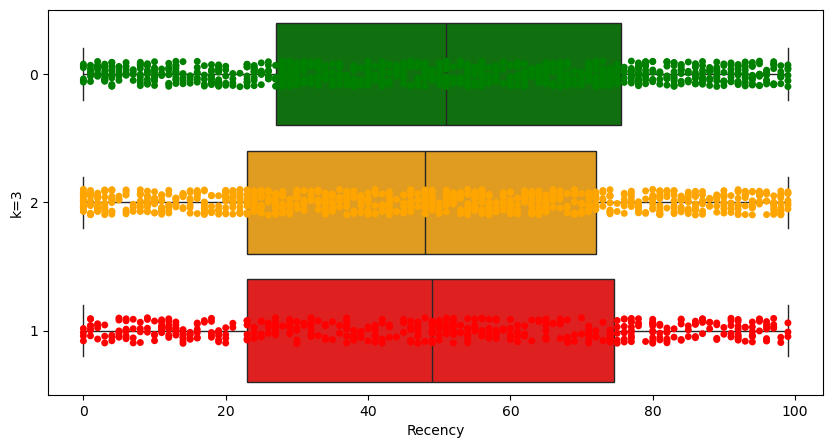

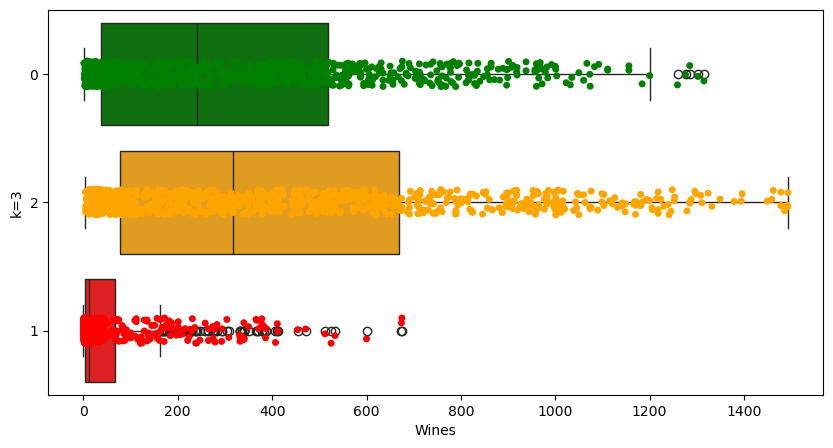

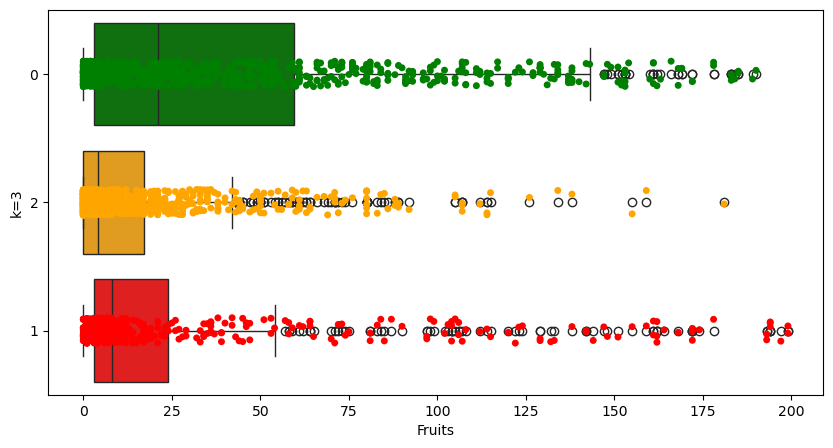

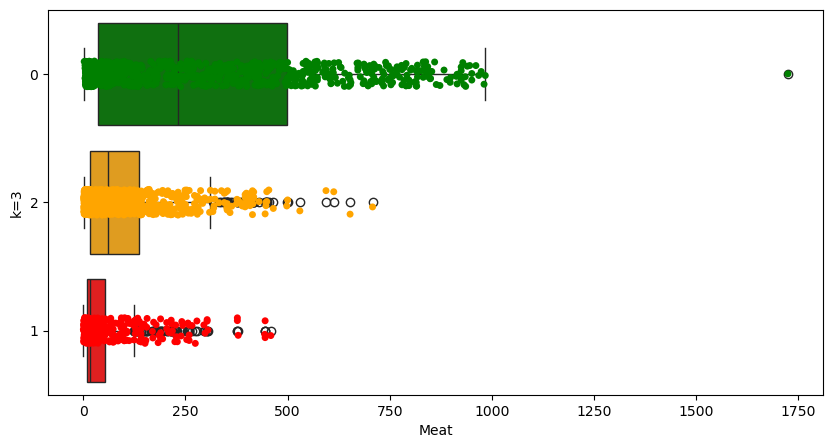

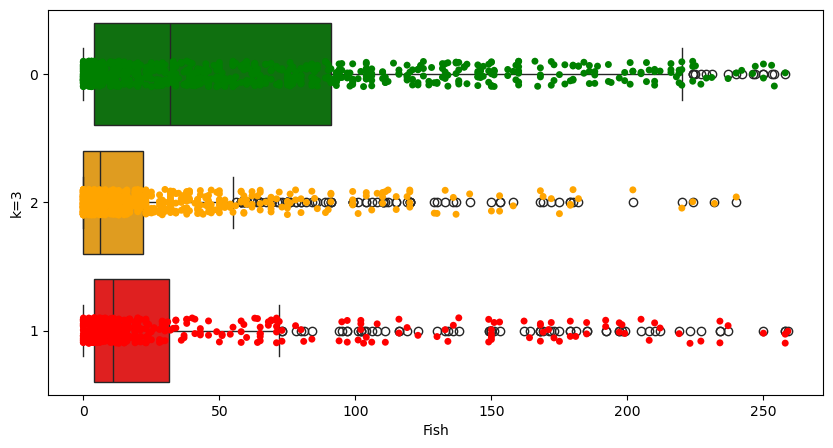

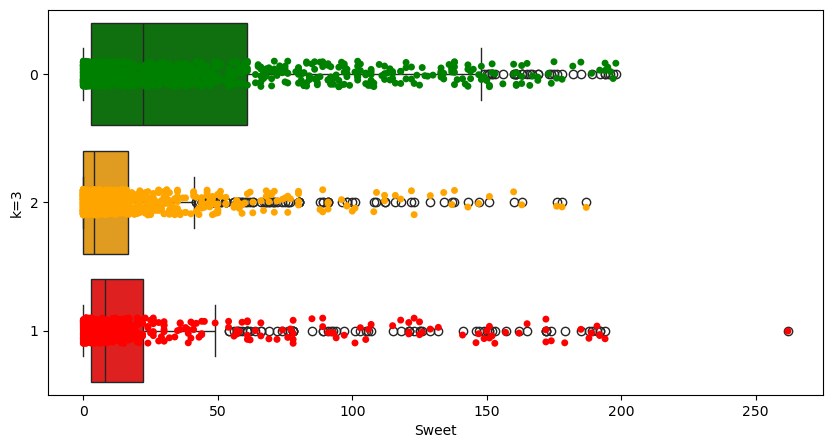

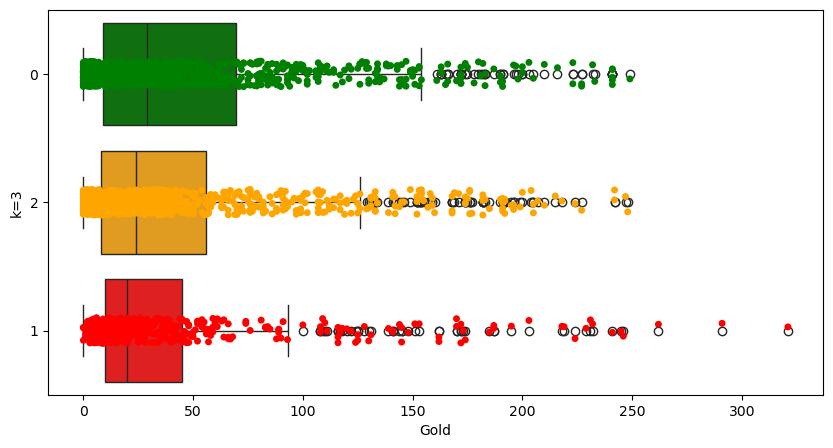

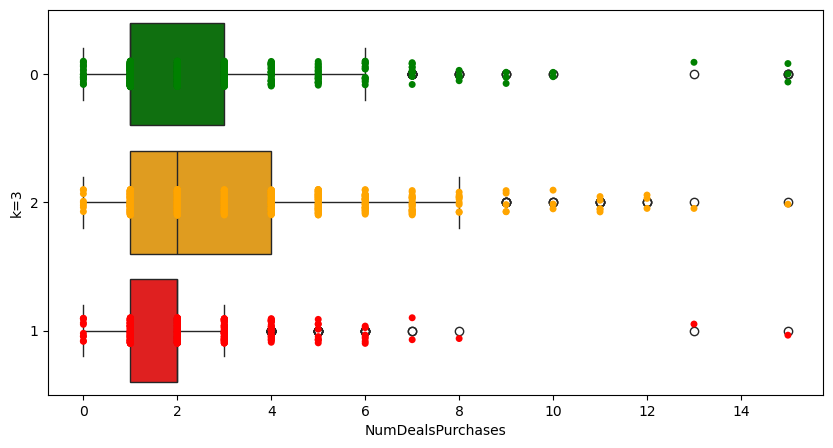

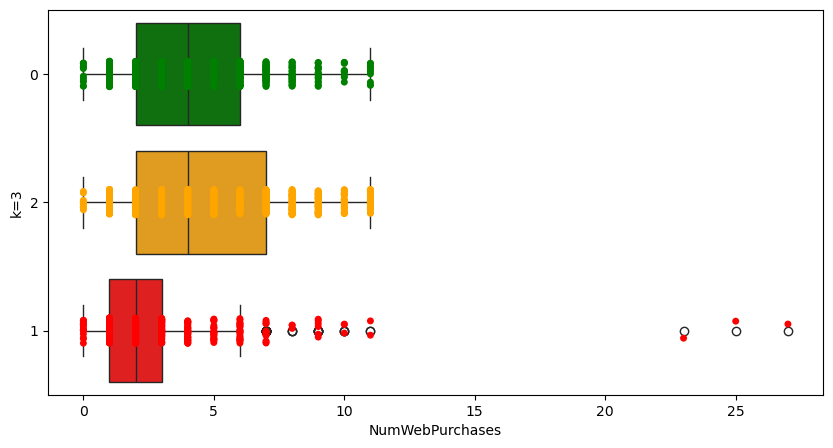

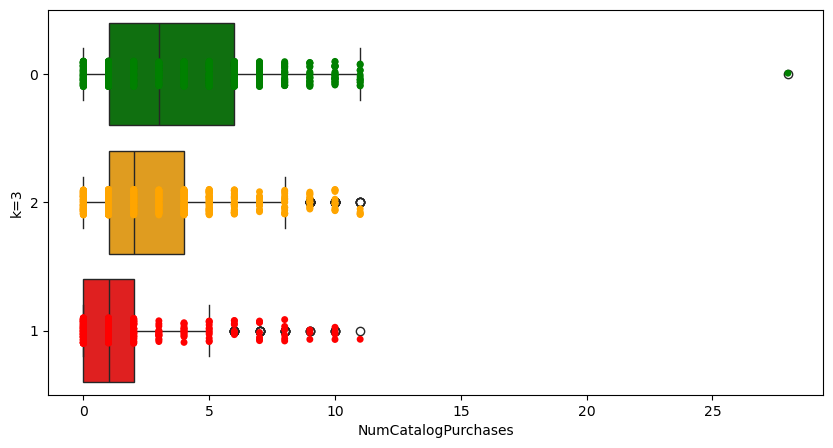

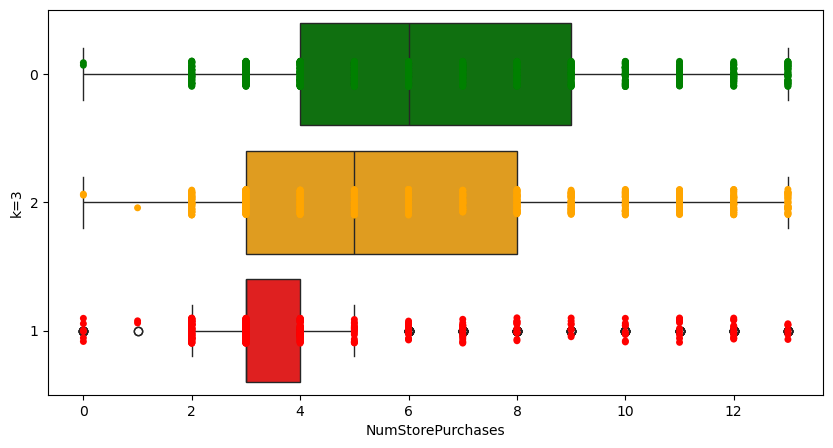

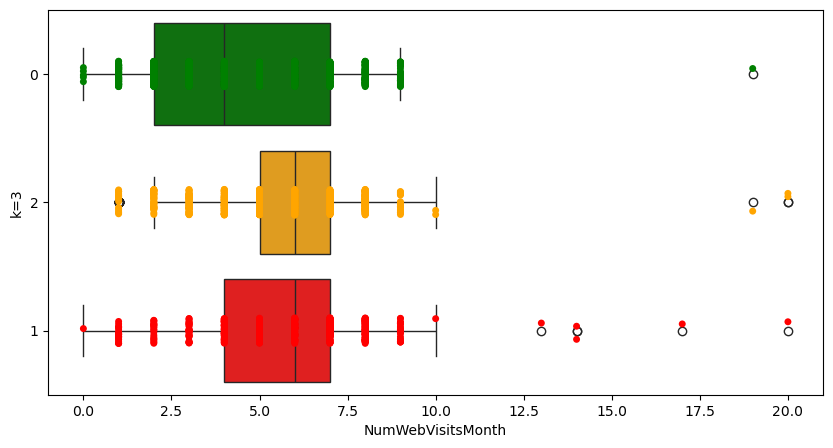

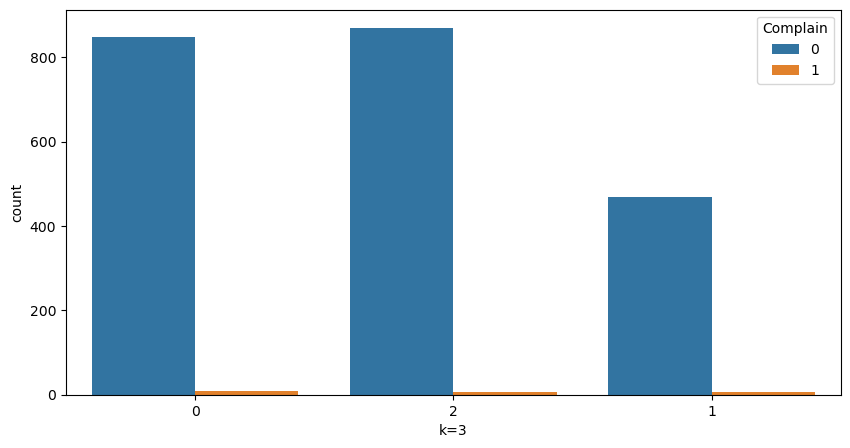

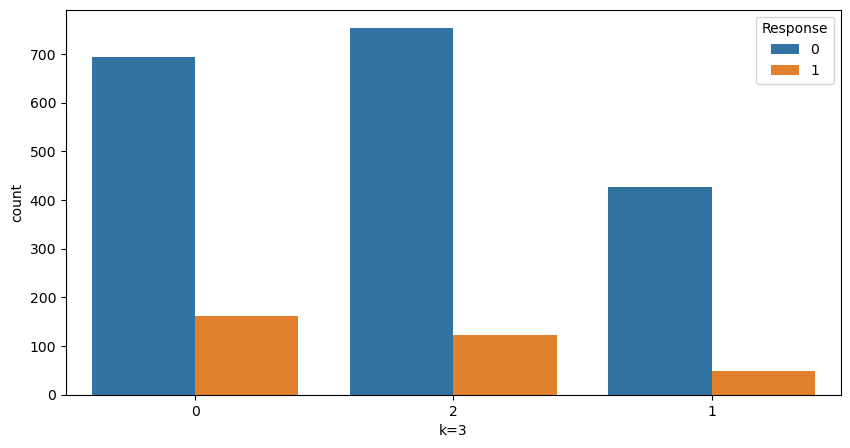

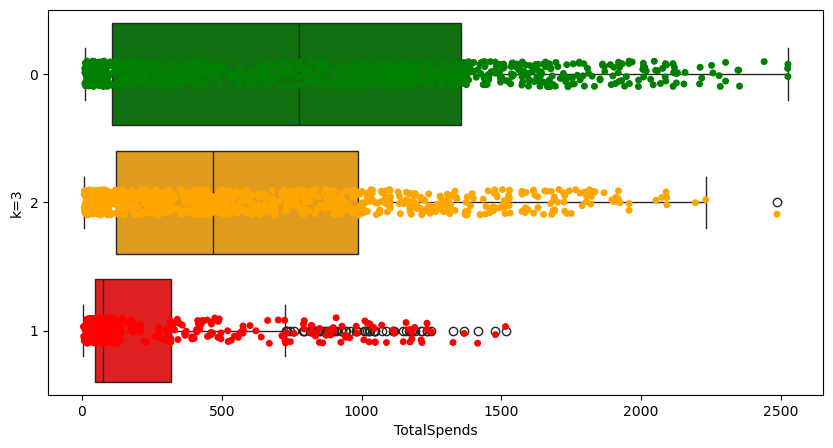

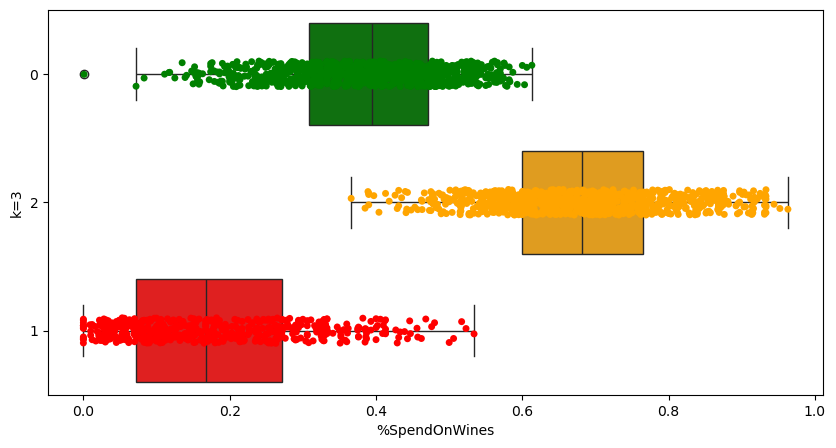

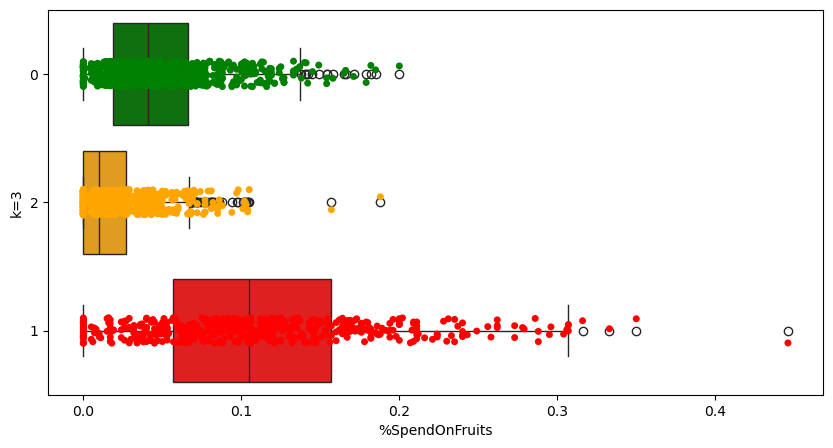

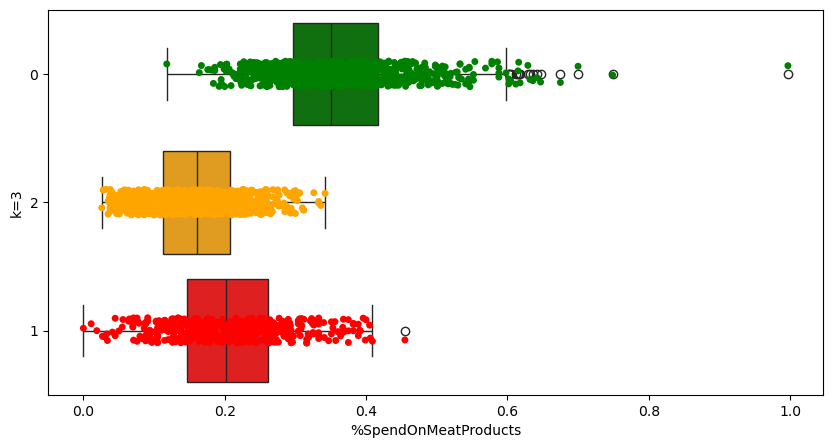

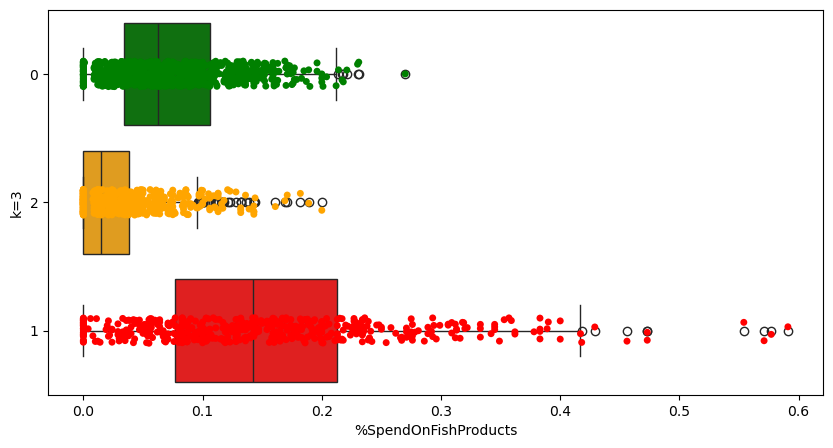

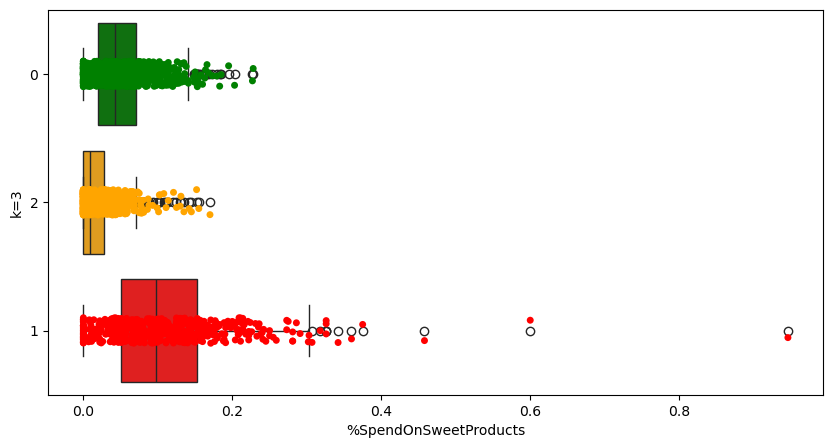

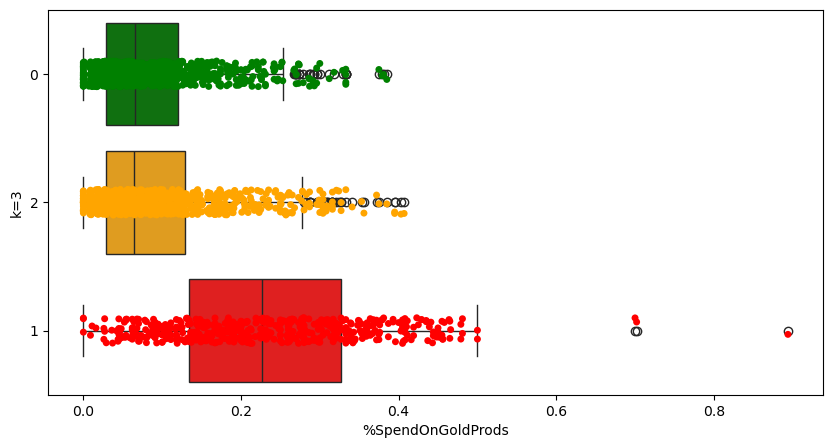

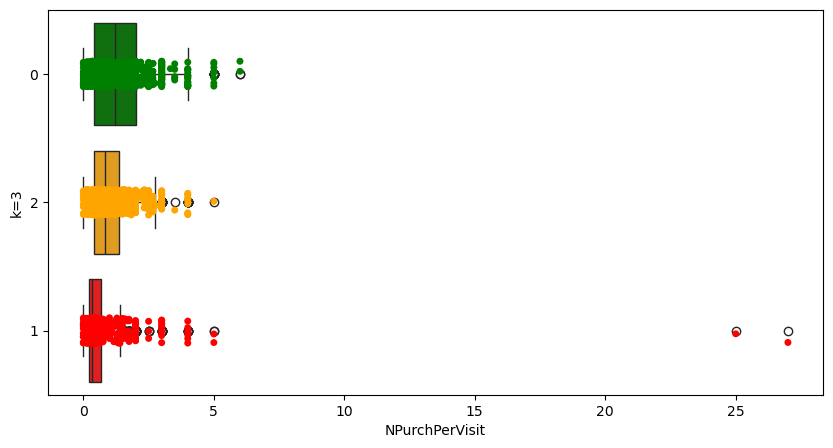

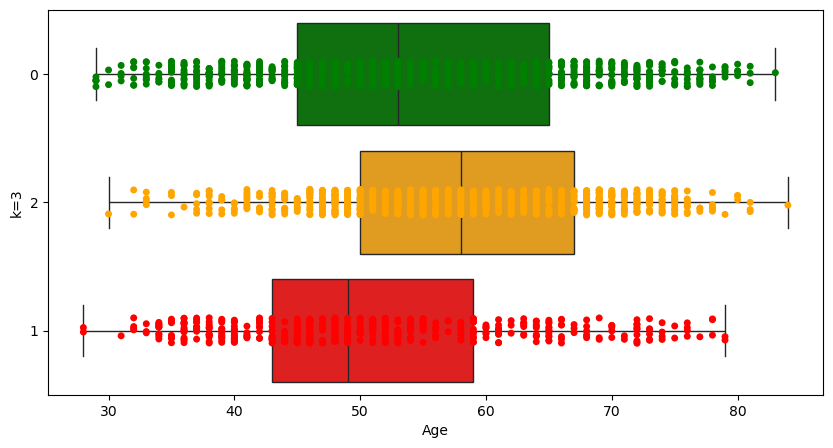

In [65]:
# features' distributions by cluster
for col in COLS_TO_DISPLAY:
    _ = plt.figure(figsize=(10, 5))
    if col not in ['Kidhome', "Complain", "Response", "YearsBeingCustomer", 'Relationship'] + list(df.dtypes[df.dtypes == "object"].index):
        _ = sns.boxplot(
            data=df, x=col, y="k=3", orient="h",
            palette=PALETTE['k=3']
        )
        _ = sns.stripplot(
            data=df, x=col, y="k=3", orient="h",
            palette=PALETTE['k=3']
        )
    else:
        _ = sns.countplot(data=df, x="k=3", hue=col)

In [66]:
# define additional columns to describe clusters by
PLOT_PARAMS['k=3'] = [
    'Meat',
    'NumCatalogPurchases',
    'NPurchPerVisit'
]

In [67]:
# compute medians by the features based on

# -- the whole dataset
df_stats = pd.DataFrame(df[PLOT_PARAMS['k=2'] + PLOT_PARAMS['k=3']].describe(percentiles=[0.5]).loc['50%']).T.reset_index(drop=True)
df_stats['k=3'] = 'Overall'

# -- by cluster
df_stats_kmeans = df.groupby(['k=3'], sort=False)[PLOT_PARAMS['k=2'] + PLOT_PARAMS['k=3']].apply(lambda x: x.describe(percentiles=[0.5]).loc['50%']).reset_index()

# concatenate dataframes with statistics
df_stats = pd.concat((df_stats_kmeans, df_stats)).reset_index(drop=True)
del df_stats_kmeans

df_stats.set_index('k=3', inplace=True)
df_stats

Wines  TotalSpends     Income  %SpendOnWines  %SpendOnFruits  \
k=3                                                                      
0       240.000      777.000 124670.000          0.394           0.041   
2       318.000      467.000 108216.000          0.682           0.010   
1        11.000       76.000  60046.000          0.167           0.105   
Overall 178.000      397.000 102574.000          0.459           0.030   

         %SpendOnFishProducts  %SpendOnSweetProducts  %SpendOnGoldProds  \
k=3                                                                       
0                       0.063                  0.042              0.065   
2                       0.015                  0.009              0.064   
1                       0.142                  0.098              0.227   
Overall                 0.048                  0.033              0.086   

           Meat  NumCatalogPurchases  NPurchPerVisit  
k=3                                                   
0       231.000                3.000           1.200  
2        61.000                2.000           0.833  
1        15.000                1.000           0.333  
Overall  68.000                2.000           0.750

In [69]:
# convert data types for fancy visualization in the app
for col in ['TotalSpends', 'Income', 'Meat', 'NumCatalogPurchases', 'Wines']:
    df_stats[col] = df_stats[col].astype(int)

# round for for fancy visualization in the app
for col in COLS_TO_TRAIN:
    if col in df_stats.columns:
        df_stats[col] = df_stats[col].round(3)

df_stats['NPurchPerVisit'] = df_stats['NPurchPerVisit'].round(1)

In [70]:
df_stats

Wines  TotalSpends  Income  %SpendOnWines  %SpendOnFruits  \
k=3                                                                  
0          240          777  124670          0.394           0.041   
2          318          467  108216          0.682           0.010   
1           11           76   60046          0.167           0.105   
Overall    178          397  102574          0.459           0.030   

         %SpendOnFishProducts  %SpendOnSweetProducts  %SpendOnGoldProds  Meat  \
k=3                                                                             
0                       0.063                  0.042              0.065   231   
2                       0.015                  0.009              0.064    61   
1                       0.142                  0.098              0.227    15   
Overall                 0.048                  0.033              0.086    68   

         NumCatalogPurchases  NPurchPerVisit  
k=3                                           
0                          3           1.200  
2                          2           0.800  
1                          1           0.300  
Overall                    2           0.800

In [71]:
df_stats.to_pickle(os.path.join(DATA_PATH, 'k_means_keq3.pckl'))

# Visualize clusters with PCA

[Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is a linear dimensionality reduction technique with applications in exploratory data analysis, visualization and data preprocessing.

The data is linearly transformed onto a new coordinate system such that the directions (principal components) capturing the largest variation in the data can be easily identified.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/1024px-GaussianScatterPCA.svg.png" width='400' height="341">

More about PCA in sklearn: [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [72]:
pca = PCA(n_components=3)

In [73]:
print("Original shape: ", df_stnd[COLS_TO_TRAIN].shape)

Original shape:  (2205, 6)


In [74]:
df[[f"PCA.{i}" for i in range(1, 4)]] = pca.fit_transform(df_stnd[COLS_TO_TRAIN])

In [75]:
print("Cumulative % of explained variance: ", np.cumsum(pca.explained_variance_ratio_))

Cumulative % of explained variance:  [0.44142808 0.64678782 0.77692838]


In [76]:
# change type for fancy visualization
df["k=3"] = df["k=3"].astype(str)

In [77]:
# k=2
fig = px.scatter_3d(
    df, x='PCA.1', y='PCA.2', z='PCA.3',size=[0.01]*len(df),
    color='k=2',color_discrete_map=PALETTE['k=2']
)                    
fig.show()

In [78]:
# k=3
fig = px.scatter_3d(
    df, x='PCA.1', y='PCA.2', z='PCA.3',size=[0.01]*len(df),
    color='k=3',color_discrete_map=PALETTE['k=3']
)                    
fig.show()

In [79]:
# save the DataFrame with clusters for the app runing
df.to_pickle(os.path.join(DATA_PATH, "clusters.pckl"))